# 🔥 지역난방 열수요 예측을 위한 시계열 데이터 전처리

## 📋 프로젝트 개요
- **목표**: 기상변수를 활용한 지역난방 열수요 예측 모델 개발
- **데이터**: 2021-2022년 1시간 단위 기상 + 열수요 데이터
- **전처리**: 결측치 처리, 파생변수 생성, 스케일링, 인코딩

In [7]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

print("📚 라이브러리 로드 완료!")

📚 라이브러리 로드 완료!


## 1️⃣ 데이터 로드

In [8]:
def load_data(train_path, test_path=None):
    """
    훈련 데이터와 테스트 데이터를 로드합니다.
    
    Parameters:
    train_path (str): 훈련 데이터 파일 경로
    test_path (str): 테스트 데이터 파일 경로 (선택사항)
    
    Returns:
    tuple: (train_df, test_df) 또는 train_df만
    """
    print("📊 데이터 로드 중...")
    
    # 훈련 데이터 로드
    train_df = pd.read_csv(train_path)
    print(f"✅ 훈련 데이터 로드 완료: {train_df.shape}")
    print(f"   컬럼: {list(train_df.columns)}")
    
    # Unnamed 컬럼 제거
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop(columns=['Unnamed: 0'])
        print("   Unnamed: 0 컬럼 제거")
    
    # 테스트 데이터 로드 (있는 경우)
    if test_path:
        test_df = pd.read_csv(test_path)
        print(f"✅ 테스트 데이터 로드 완료: {test_df.shape}")
        
        if 'Unnamed: 0' in test_df.columns:
            test_df = test_df.drop(columns=['Unnamed: 0'])
            print("   Unnamed: 0 컬럼 제거")
        
        return train_df, test_df
    else:
        return train_df

# 데이터 로드 (파일 경로를 실제 경로로 변경하세요)
# train_df = load_data('train_heat.csv')
# test_df가 별도로 있다면: train_df, test_df = load_data('train_heat.csv', 'test_heat.csv')


train_df, test_df = load_data('train_heat_ABD.csv', 'test_heat_ABD.csv')

📊 데이터 로드 중...
✅ 훈련 데이터 로드 완료: (52557, 11)
   컬럼: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
✅ 테스트 데이터 로드 완료: (26280, 11)


In [9]:
# 데이터 기본 정보 확인
print(f"\n📈 데이터 기본 정보:")
print(f"   데이터 형태: {train_df.shape}")
print(f"   지사별 데이터 수:")
if 'train_heat.branch_id' in train_df.columns:
    print(train_df['train_heat.branch_id'].value_counts().head())
elif 'branch_id' in train_df.columns:
    print(train_df['branch_id'].value_counts().head())

# 결측치 현황 확인
print(f"\n📊 결측치 현황:")
missing_info = train_df.isnull().sum()
print(missing_info[missing_info > 0])


📈 데이터 기본 정보:
   데이터 형태: (52557, 11)
   지사별 데이터 수:
branch_id
A    17519
B    17519
D    17519
Name: count, dtype: int64

📊 결측치 현황:
Series([], dtype: int64)


In [10]:
# 컬럼명에서 'train_heat.' 접두사 제거
print("🔧 컬럼명 정리 중...")
print(f"   기존 컬럼명: {list(train_df.columns)}")

# 'train_heat.' 접두사 제거
train_df.columns = train_df.columns.str.replace('train_heat.', '', regex=False)

print(f"   변경된 컬럼명: {list(train_df.columns)}")

🔧 컬럼명 정리 중...
   기존 컬럼명: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
   변경된 컬럼명: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


## 2️⃣ 결측치 처리

In [11]:
def handle_missing_values(df):
    """
    결측치를 처리합니다.
    1. -99 값을 NaN으로 변환
    2. 일사량(si) 특별 처리 (야간시간 0 처리)
    3. 지사별 선형보간
    """
    print("🔧 결측치 처리 시작...")
    df = df.copy()
    
    # 컬럼명 정리 (train_heat. 접두사 제거)
    df.columns = [col.replace('train_heat.', '') for col in df.columns]
    print(f"   컬럼명 정리 완료: {list(df.columns)}")
    
    # 2-1. -99 값을 NaN으로 변환
    print("   🔄 -99 값을 NaN으로 변환 중...")
    missing_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
    before_count = 0
    for col in missing_cols:
        if col in df.columns:
            count = (df[col] == -99).sum()
            before_count += count
            df[col] = df[col].replace(-99, np.nan)
    
    print(f"   ✅ 총 {before_count}개의 -99 값을 NaN으로 변환")
    
    # 2-2. 일사량(si) 특별 처리
    if 'si' in df.columns and 'tm' in df.columns:
        print("   ☀️ 일사량(si) 특별 처리 중...")
        
        # tm을 datetime으로 변환
        df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
        df['hour'] = df['datetime'].dt.hour
        
        # 야간시간대 (18시-08시) NaN을 0으로 처리
        night_mask = (df['hour'] < 8) | (df['hour'] > 18)
        night_nan_count = df.loc[night_mask, 'si'].isna().sum()
        df.loc[night_mask & df['si'].isna(), 'si'] = 0
        
        print(f"   ✅ 야간시간대 일사량 {night_nan_count}개를 0으로 처리")
    
    # 2-3. 지사별 선형보간
    print("   📈 지사별 선형보간 처리 중...")
    
    if 'branch_id' in df.columns:
        # datetime 기준으로 정렬
        df = df.sort_values(['branch_id', 'datetime'])
        
        # 지사별로 그룹화하여 선형보간
        for branch in df['branch_id'].unique():
            branch_mask = df['branch_id'] == branch
            branch_data = df[branch_mask].copy()
            
            # 각 수치형 컬럼에 대해 선형보간
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if col in branch_data.columns:
                    # 시간 순서로 선형보간
                    branch_data[col] = branch_data[col].interpolate(method='linear')
                    # 앞뒤 결측치는 forward/backward fill
                    branch_data[col] = branch_data[col].fillna(method='ffill').fillna(method='bfill')
            
            # 원본 데이터에 반영
            df.loc[branch_mask, numeric_cols] = branch_data[numeric_cols]
    
    # 결측치 처리 결과 확인
    missing_after = df.isnull().sum()
    missing_cols_after = missing_after[missing_after > 0]
    
    print(f"   ✅ 선형보간 완료")
    if len(missing_cols_after) > 0:
        print(f"   ⚠️ 남은 결측치: {missing_cols_after.to_dict()}")
    else:
        print(f"   🎉 모든 결측치 처리 완료!")
    
    return df

# 결측치 처리 실행
train_df = handle_missing_values(train_df)

🔧 결측치 처리 시작...
   컬럼명 정리 완료: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
   🔄 -99 값을 NaN으로 변환 중...
   ✅ 총 54449개의 -99 값을 NaN으로 변환
   ☀️ 일사량(si) 특별 처리 중...
   ✅ 야간시간대 일사량 23796개를 0으로 처리
   📈 지사별 선형보간 처리 중...
   ✅ 선형보간 완료
   🎉 모든 결측치 처리 완료!


## 3️⃣ 기상 시계열 파생변수 생성

In [12]:
def create_weather_time_features(df):
    """
    기상 데이터를 기반으로 시계열 파생변수를 생성합니다.
    """
    print("🌡️ 기상 시계열 파생변수 생성 중...")
    df = df.copy()
    
    # 3-1. 시간 기본 변수 생성
    print("   📅 시간 기본 변수 생성...")
    if 'datetime' not in df.columns and 'tm' in df.columns:
        df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek  # 0:월요일, 6:일요일
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['week'] = df['datetime'].dt.isocalendar().week
    
    # 3-2. 계절성 반영 변수 (순환형 인코딩)
    print("   🔄 계절성 순환 변수 생성...")
    
    # 시간의 순환성을 sin/cos로 표현
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    # 계절 구분
    df['season'] = df['month'].map({12: 0, 1: 0, 2: 0,  # 겨울
                                   3: 1, 4: 1, 5: 1,    # 봄
                                   6: 2, 7: 2, 8: 2,    # 여름
                                   9: 3, 10: 3, 11: 3}) # 가을
    
    return df

# 기상 시계열 파생변수 생성 실행
train_df = create_weather_time_features(train_df)
print("✅ 시간 기본 변수 및 순환 변수 생성 완료")

🌡️ 기상 시계열 파생변수 생성 중...
   📅 시간 기본 변수 생성...
   🔄 계절성 순환 변수 생성...
✅ 시간 기본 변수 및 순환 변수 생성 완료


In [13]:
def create_heating_related_features(df):
    """
    난방 관련 시간 변수를 생성합니다.
    """
    print("🔥 난방 관련 시간 변수 생성...")
    df = df.copy()
    
    # 난방시즌 (10월-4월)
    df['heating_season'] = df['month'].isin([10, 11, 12, 1, 2, 3, 4]).astype(int)
    # 피크 난방시즌 (12월-2월)
    df['peak_heating'] = df['month'].isin([12, 1, 2]).astype(int)
    # 중간계절 (3-4월, 10-11월)
    df['shoulder_season'] = df['month'].isin([3, 4, 10, 11]).astype(int)
    
    # 시간대별 구분
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_work_hour'] = ((df['hour'] >= 9) & (df['hour'] <= 18)).astype(int)
    df['is_peak_morning'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['is_peak_evening'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)
    df['is_night'] = ((df['hour'] >= 23) | (df['hour'] <= 6)).astype(int)
    
    print("   ✅ 난방 관련 시간 변수 생성 완료")
    return df

train_df = create_heating_related_features(train_df)

🔥 난방 관련 시간 변수 생성...
   ✅ 난방 관련 시간 변수 생성 완료


In [14]:
def create_weather_derived_features(df):
    """
    기상 파생변수를 생성합니다.
    """
    print("🌤️ 기상 파생변수 생성...")
    df = df.copy()
    
    # 난방도일 (HDD) & 냉방도일 (CDD)
    base_temp_heating = 18.0  # 난방 기준온도
    base_temp_cooling = 26.0  # 냉방 기준온도
    
    if 'ta' in df.columns:
        df['HDD_18'] = np.maximum(base_temp_heating - df['ta'], 0)
        # df['HDD_20'] = np.maximum(20 - df['ta'], 0)  # 추가 기준온도
        # df['CDD_26'] = np.maximum(df['ta'] - base_temp_cooling, 0)
    
    # # 체감온도 계산 (풍속 고려)
    # if 'ta' in df.columns and 'ws' in df.columns:
    #     df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * (df['ws'] ** 0.16) + 0.3965 * df['ta'] * (df['ws'] ** 0.16)
    
    # 불쾌지수 (온도 + 습도)
    if 'ta' in df.columns and 'hm' in df.columns:
        df['discomfort_index'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3
    
    # 기온 범주화
    if 'ta' in df.columns:
        df['temp_category'] = pd.cut(df['ta'], 
                                   bins=[-np.inf, 0, 10, 20, 30, np.inf], 
                                   labels=[0, 1, 2, 3, 4])  # 매우추움~더움
        df['temp_category'] = df['temp_category'].astype(int)
    
    # 강수 관련
    if 'rn_day' in df.columns:
        df['is_rainy'] = (df['rn_day'] > 0).astype(int)
        df['is_heavy_rain'] = (df['rn_day'] > 10).astype(int)
        df['rain_intensity'] = pd.cut(df['rn_day'], 
                                    bins=[-1, 0, 1, 5, 10, np.inf], 
                                    labels=[0, 1, 2, 3, 4])
        df['rain_intensity'] = df['rain_intensity'].astype(int)
    
    print("   ✅ 기상 파생변수 생성 완료")
    return df

train_df = create_weather_derived_features(train_df)

🌤️ 기상 파생변수 생성...
   ✅ 기상 파생변수 생성 완료


In [15]:
def create_rolling_and_lag_features(df):
    """
    Rolling 통계 및 지연 변수를 생성합니다.
    """
    print("📊 Rolling 통계 및 지연 변수 생성...")
    df = df.copy()
    
    # 지사별로 그룹화하여 처리
    if 'branch_id' in df.columns:
        df = df.sort_values(['branch_id', 'datetime'])
        
        for branch in df['branch_id'].unique():
            branch_mask = df['branch_id'] == branch
            branch_data = df[branch_mask].copy()
            
            # 기온 관련 rolling 통계
            if 'ta' in branch_data.columns:
                for window in [6, 12, 24, 48]:
                    rolling_ta = branch_data['ta'].rolling(window=window, min_periods=1)
                    branch_data[f'ta_mean_{window}h'] = rolling_ta.mean()
                    branch_data[f'ta_std_{window}h'] = rolling_ta.std().fillna(0)  # std가 NaN일 수 있음
                    branch_data[f'ta_max_{window}h'] = rolling_ta.max()
                    branch_data[f'ta_min_{window}h'] = rolling_ta.min()
                
                # 기온 차분 및 변화율
                branch_data['ta_diff_1h'] = branch_data['ta'].diff()
                branch_data['ta_diff_24h'] = branch_data['ta'].diff(periods=24)
                
                # Lag 변수
                for lag in [1, 2, 3, 6, 12, 24]:
                    branch_data[f'ta_lag_{lag}'] = branch_data['ta'].shift(lag)
            
            # HDD rolling 합계
            if 'HDD_18' in branch_data.columns:
                for window in [6, 12, 24, 48]:
                    branch_data[f'HDD_sum_{window}h'] = branch_data['HDD_18'].rolling(window=window, min_periods=1).sum()
            
            # 강수량 누적
            if 'rn_hr1' in branch_data.columns:
                for window in [3, 6, 12, 24]:
                    branch_data[f'rain_sum_{window}h'] = branch_data['rn_hr1'].rolling(window=window, min_periods=1).sum()
            
            # 무한값 및 NaN 체크 및 처리
            for col in branch_data.columns:
                if branch_data[col].dtype in ['float64', 'float32']:
                    # 무한값을 NaN으로 변환
                    branch_data[col] = branch_data[col].replace([np.inf, -np.inf], np.nan)
                    # NaN을 적절한 값으로 변환 (rolling 통계는 0, lag는 forward fill)
                    if any(keyword in col for keyword in ['_mean_', '_std_', '_max_', '_min_', '_sum_', '_diff_']):
                        branch_data[col] = branch_data[col].fillna(0)
                    elif '_lag_' in col:
                        branch_data[col] = branch_data[col].fillna(method='ffill').fillna(0)
            
            # 원본 데이터에 반영
            new_cols = [col for col in branch_data.columns if col not in df.columns]
            if new_cols:
                df.loc[branch_mask, new_cols] = branch_data[new_cols]
    
    rolling_cols = len([col for col in df.columns if any(keyword in col for keyword in ['_mean_', '_std_', '_max_', '_min_', '_sum_', '_lag_', '_diff_'])])
    print(f"   ✅ Rolling 통계 및 지연 변수 생성 완료! (총 {rolling_cols}개)")
    
    return df

train_df = create_rolling_and_lag_features(train_df)

📊 Rolling 통계 및 지연 변수 생성...
   ✅ Rolling 통계 및 지연 변수 생성 완료! (총 32개)


## 4️⃣ 열수요 관련 파생변수 생성

In [16]:
def create_heat_demand_features(df):
    """
    열수요 관련 파생변수를 생성합니다.
    """
    print("🔥 열수요 관련 파생변수 생성 중...")
    df = df.copy()
    
    if 'heat_demand' not in df.columns:
        print("   ⚠️ heat_demand 컬럼이 없어서 건너뜁니다.")
        return df
    
    # 지사별로 그룹화하여 처리
    if 'branch_id' in df.columns:
        df = df.sort_values(['branch_id', 'datetime'])
        
        for branch in df['branch_id'].unique():
            branch_mask = df['branch_id'] == branch
            branch_data = df[branch_mask].copy()
            
            # 4-1. 열수요 Lag 변수
            for lag in [1, 2, 3, 6, 12, 24, 48]:
                branch_data[f'demand_lag_{lag}'] = branch_data['heat_demand'].shift(lag)
            
            # 4-2. 열수요 Rolling 통계
            for window in [6, 12, 24, 48]:
                rolling_demand = branch_data['heat_demand'].rolling(window=window, min_periods=1)
                branch_data[f'demand_mean_{window}h'] = rolling_demand.mean()
                branch_data[f'demand_std_{window}h'] = rolling_demand.std()
                branch_data[f'demand_max_{window}h'] = rolling_demand.max()
                branch_data[f'demand_min_{window}h'] = rolling_demand.min()
            
            # 4-3. 열수요 변화율 및 차분
            branch_data['demand_diff_1h'] = branch_data['heat_demand'].diff()
            branch_data['demand_diff_24h'] = branch_data['heat_demand'].diff(periods=24)
            branch_data['demand_pct_change_1h'] = branch_data['heat_demand'].pct_change()
            
            # 4-4. 계절성 및 주기성 특성
            # 같은 시간대 평균 대비 비율
            hourly_avg = branch_data.groupby('hour')['heat_demand'].transform('mean')
            branch_data['demand_vs_hourly_avg'] = branch_data['heat_demand'] / (hourly_avg + 1e-8)
            
            # 4-5. 효율성 지표
            if 'HDD_18' in branch_data.columns:
                branch_data['heating_efficiency'] = branch_data['heat_demand'] / (branch_data['HDD_18'] + 1e-8)
            
            if 'ta' in branch_data.columns:
                branch_data['temp_sensitivity'] = branch_data['demand_diff_1h'] / (branch_data['ta_diff_1h'] + 1e-8)
            
            # 원본 데이터에 반영
            new_cols = [col for col in branch_data.columns if col.startswith('demand_') or col in ['heating_efficiency', 'temp_sensitivity']]
            df.loc[branch_mask, new_cols] = branch_data[new_cols]
    
    demand_cols = len([col for col in df.columns if col.startswith('demand_') or col in ['heating_efficiency', 'temp_sensitivity']])
    print(f"   ✅ 열수요 관련 파생변수 생성 완료! (총 {demand_cols}개)")
    
    return df

# 열수요 관련 파생변수 생성 실행
train_df = create_heat_demand_features(train_df)

🔥 열수요 관련 파생변수 생성 중...
   ✅ 열수요 관련 파생변수 생성 완료! (총 29개)


## 5️⃣ 상호작용 특성 생성

In [17]:
def create_interaction_features(df):
    """
    상호작용 특성을 생성합니다.
    """
    print("🔗 상호작용 특성 생성 중...")
    df = df.copy()
    
    # 기온과 시간의 상호작용
    if 'ta' in df.columns:
        df['ta_hour_interaction'] = df['ta'] * df['hour']
        df['ta_month_interaction'] = df['ta'] * df['month']
        df['ta_weekend_interaction'] = df['ta'] * df['is_weekend']
    
    # HDD와 시간의 상호작용
    if 'HDD_18' in df.columns:
        df['hdd_hour_interaction'] = df['HDD_18'] * df['hour']
        df['hdd_weekend_interaction'] = df['HDD_18'] * df['is_weekend']
    
    # 기온과 습도의 상호작용
    if 'ta' in df.columns and 'hm' in df.columns:
        df['ta_humidity_interaction'] = df['ta'] * df['hm']
    
    # 풍속과 기온의 상호작용
    if 'ws' in df.columns and 'ta' in df.columns:
        df['wind_temp_interaction'] = df['ws'] * df['ta']
    
    # 강수와 계절의 상호작용
    if 'rn_day' in df.columns:
        df['rain_season_interaction'] = df['rn_day'] * df['season']
        df['rain_weekend_interaction'] = df['rn_day'] * df['is_weekend']
    
    # 지사별 상호작용 (상위 3개 지사만)
    if 'branch_id' in df.columns and 'ta' in df.columns:
        top_branches = df['branch_id'].value_counts().head(3).index.tolist()
        for branch in top_branches:
            branch_dummy = (df['branch_id'] == branch).astype(int)
            df[f'branch_{branch}_temp'] = branch_dummy * df['ta']
            if 'HDD_18' in df.columns:
                df[f'branch_{branch}_hdd'] = branch_dummy * df['HDD_18']
    
    interaction_cols = [col for col in df.columns if 'interaction' in col or col.startswith('branch_')]
    print(f"   ✅ 상호작용 특성 생성 완료! (총 {len(interaction_cols)}개)")
    
    return df

# 상호작용 특성 생성 실행
train_df = create_interaction_features(train_df)

🔗 상호작용 특성 생성 중...
   ✅ 상호작용 특성 생성 완료! (총 16개)


## 6️⃣ 최종 전처리 및 인코딩

In [18]:
def prepare_final_features(df, target_col='heat_demand'):
    """
    최종 특성 준비, 인코딩, 스케일링을 수행합니다.
    """
    print("🎯 최종 특성 준비 중...")
    df = df.copy()
    
    # 6-1. 결측치 최종 처리
    print("   🔧 결측치 최종 처리...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # 6-2. 특성 선택
    print("   📝 특성 선택...")
    
    # 제외할 컬럼들
    exclude_cols = ['tm', 'datetime', 'year']  # 기본 제외
    if target_col in df.columns:
        exclude_cols.append(target_col)  # 타겟 변수 제외
    
    # 사용할 특성 컬럼 선택
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # 범주형 컬럼 식별
    categorical_cols = []
    if 'branch_id' in feature_cols:
        categorical_cols.append('branch_id')
    
    print(f"   ✅ 총 {len(feature_cols)}개 특성 선택")
    print(f"   📋 범주형 변수: {categorical_cols}")
    
    # 6-3. 원핫 인코딩
    print("   🔄 원핫 인코딩 수행...")
    if categorical_cols:
        df_encoded = pd.get_dummies(df[feature_cols + [target_col] if target_col in df.columns else feature_cols], 
                                  columns=categorical_cols, 
                                  prefix=categorical_cols)
        print(f"   ✅ 원핫 인코딩 완료: {df_encoded.shape[1] - len(df[feature_cols].columns)}개 더미 변수 생성")
    else:
        df_encoded = df[feature_cols + [target_col] if target_col in df.columns else feature_cols].copy()
    
    # 6-4. 스케일링
    print("   📏 스케일링 수행...")
    
    if target_col in df_encoded.columns:
        feature_cols_encoded = [col for col in df_encoded.columns if col != target_col]
        X = df_encoded[feature_cols_encoded]
        y = df_encoded[target_col]
    else:
        feature_cols_encoded = df_encoded.columns.tolist()
        X = df_encoded
        y = None
    
    # 무한값 및 극값 처리
    print("   🔧 무한값 및 극값 처리...")
    
    # 무한값을 NaN으로 변환
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # 극값 처리 (99.9% 분위수로 클리핑)
    for col in X.columns:
        if X[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            # 분위수 계산 (NaN 제외)
            q99 = X[col].quantile(0.999)
            q01 = X[col].quantile(0.001)
            
            # 극값 클리핑
            X[col] = X[col].clip(lower=q01, upper=q99)
    
    # 남은 NaN 값 처리
    X = X.fillna(X.median()).fillna(0)
    
    # 데이터 타입 확인 및 변환
    X = X.astype(np.float64)
    
    # 최종 무한값 체크
    if np.any(np.isinf(X.values)) or np.any(np.isnan(X.values)):
        print("   ⚠️ 여전히 무한값/NaN이 존재합니다. 추가 처리 중...")
        # 남은 문제 컬럼 확인
        remaining_inf_cols = X.columns[np.any(np.isinf(X.values), axis=0)]
        remaining_nan_cols = X.columns[np.any(np.isnan(X.values), axis=0)]
        if len(remaining_inf_cols) > 0:
            print(f"      - 남은 무한값 컬럼: {list(remaining_inf_cols)}")
        if len(remaining_nan_cols) > 0:
            print(f"      - 남은 NaN 컬럼: {list(remaining_nan_cols)}")
        X = X.replace([np.inf, -np.inf, np.nan], 0)
    # MinMax 스케일링
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols_encoded, index=X.index)
    
    if y is not None:
        final_df = X_scaled_df.copy()
        final_df[target_col] = y.values
    else:
        final_df = X_scaled_df.copy()
    
    print(f"   ✅ 스케일링 완료! 최종 데이터 형태: {final_df.shape}")
    
    return final_df, scaler, feature_cols_encoded

# 최종 전처리 실행
final_train_df, scaler, feature_columns = prepare_final_features(train_df)

🎯 최종 특성 준비 중...
   🔧 결측치 최종 처리...
   📝 특성 선택...
   ✅ 총 114개 특성 선택
   📋 범주형 변수: ['branch_id']
   🔄 원핫 인코딩 수행...
   ✅ 원핫 인코딩 완료: 3개 더미 변수 생성
   📏 스케일링 수행...
   🔧 무한값 및 극값 처리...
   ✅ 스케일링 완료! 최종 데이터 형태: (52557, 117)


## 7️⃣ 데이터 분할 (필요 시 진행)

In [19]:
def split_data_by_year(df, train_years=[2021], test_years=[2022], val_ratio=0.2):
    """
    연도별로 데이터를 분할합니다.
    """
    print("📊 연도별 데이터 분할 중...")
    
    # 원본 데이터에서 연도 정보 가져오기
    df_with_year = df.copy()
    if 'year' not in df_with_year.columns and 'datetime' in train_df.columns:
        df_with_year['year'] = train_df['datetime'].dt.year
    elif 'year' not in df_with_year.columns and 'tm' in train_df.columns:
        df_with_year['year'] = train_df['tm'].astype(str).str[:4].astype(int)
    
    # 훈련 데이터
    train_mask = df_with_year['year'].isin(train_years)
    train_data = df[train_mask].copy()
    
    # 테스트 데이터
    test_mask = df_with_year['year'].isin(test_years)
    test_data = df[test_mask].copy()
    
    # 검증 데이터 (훈련 데이터에서 시간순으로 분할)
    if val_ratio > 0:
        val_size = int(len(train_data) * val_ratio)
        val_data = train_data.iloc[-val_size:].copy()
        train_data = train_data.iloc[:-val_size].copy()
    else:
        val_data = None
    
    print(f"   ✅ 데이터 분할 완료:")
    print(f"      훈련 데이터: {train_data.shape}")
    if val_data is not None:
        print(f"      검증 데이터: {val_data.shape}")
    print(f"      테스트 데이터: {test_data.shape}")
    
    return train_data, val_data, test_data

# 데이터 분할 실행
train_data, val_data, test_data = split_data_by_year(final_train_df)

📊 연도별 데이터 분할 중...
   ✅ 데이터 분할 완료:
      훈련 데이터: (21022, 117)
      검증 데이터: (5255, 117)
      테스트 데이터: (26280, 117)


## 8️⃣ 결과 요약

In [20]:
print("🎉 전처리 완료!")
print(f"\n📊 최종 데이터 정보:")
print(f"   훈련 데이터: {train_data.shape}")
# if val_data is not None:
#     print(f"   검증 데이터: {val_data.shape}")
if test_data is not None:
    print(f"   테스트 데이터: {test_data.shape}")

print(f"\n📈 생성된 특성:")
feature_types = {
    '시간 특성': [col for col in feature_columns if any(keyword in col for keyword in ['hour', 'month', 'day', 'week', 'season'])],
    '기상 기본': [col for col in feature_columns if col in ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi']],
    '기상 파생': [col for col in feature_columns if any(keyword in col for keyword in ['HDD', 'CDD', 'wind_chill', 'discomfort'])],
    'Rolling 통계': [col for col in feature_columns if any(keyword in col for keyword in ['mean_', 'std_', 'max_', 'min_', 'sum_'])],
    'Lag 변수': [col for col in feature_columns if 'lag_' in col],
    '상호작용': [col for col in feature_columns if 'interaction' in col or col.startswith('branch_')],
    '열수요 관련': [col for col in feature_columns if col.startswith('demand_')]
}

for feature_type, cols in feature_types.items():
    if cols:
        print(f"   {feature_type}: {len(cols)}개")

print(f"\n💾 데이터 저장 준비 완료")
print("   - train_data: 모델 훈련용")
# print("   - val_data: 모델 검증용") 
print("   - test_data: 최종 평가용")
print("   - scaler: 스케일러 객체 (예측시 역변환 필요)")
print("   - feature_columns: 특성 컬럼 리스트")

print("\n🚀 전처리 완료! 이제 모델링을 시작할 수 있습니다!")

🎉 전처리 완료!

📊 최종 데이터 정보:
   훈련 데이터: (21022, 117)
   테스트 데이터: (26280, 117)

📈 생성된 특성:
   시간 특성: 28개
   기상 기본: 8개
   기상 파생: 6개
   Rolling 통계: 40개
   Lag 변수: 13개
   상호작용: 18개
   열수요 관련: 27개

💾 데이터 저장 준비 완료
   - train_data: 모델 훈련용
   - test_data: 최종 평가용
   - scaler: 스케일러 객체 (예측시 역변환 필요)
   - feature_columns: 특성 컬럼 리스트

🚀 전처리 완료! 이제 모델링을 시작할 수 있습니다!


In [21]:
# # 필요시 CSV 파일로 저장
# train_data.to_csv('processed_train_data.csv', index=False)
# if val_data is not None:
#     val_data.to_csv('processed_val_data.csv', index=False)
# if test_data is not None:
#     test_data.to_csv('processed_test_data.csv', index=False)


# print("전처리 파이프라인 실행 완료! 🎯")

In [22]:
# 사용 예시: 간단한 모델 훈련
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# X_train = train_data.drop(columns=['heat_demand'])
# y_train = train_data['heat_demand']
# X_val = val_data.drop(columns=['heat_demand']) if val_data is not None else None
# y_val = val_data['heat_demand'] if val_data is not None else None

# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# if X_val is not None:
#     y_pred = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     print(f"Validation RMSE: {rmse:.4f}")

In [23]:
# 🔧 개선된 전처리 파이프라인 실행
print("🚀 개선된 전처리 파이프라인 시작!")
print("="*60)

# 1. 데이터 로드
print("\n1️⃣ 데이터 로드...")
train_df_new, test_df_new = load_data('train_heat_ABD.csv', 'test_heat_ABD.csv')

# 2. 결측치 처리
print("\n2️⃣ 결측치 처리...")
train_df_new = handle_missing_values(train_df_new)

# 3. 기상 시계열 파생변수 생성
print("\n3️⃣ 기상 시계열 파생변수 생성...")
train_df_new = create_weather_time_features(train_df_new)
train_df_new = create_heating_related_features(train_df_new)
train_df_new = create_weather_derived_features(train_df_new)

# 4. Rolling 통계 및 지연 변수 생성 (개선된 버전)
print("\n4️⃣ Rolling 통계 및 지연 변수 생성...")
train_df_new = create_rolling_and_lag_features(train_df_new)

# 5. 열수요 관련 파생변수 생성 (개선된 버전)
print("\n5️⃣ 열수요 관련 파생변수 생성...")
train_df_new = create_heat_demand_features(train_df_new)

# 6. 상호작용 특성 생성
print("\n6️⃣ 상호작용 특성 생성...")
train_df_new = create_interaction_features(train_df_new)

# 7. 최종 전처리 및 인코딩
print("\n7️⃣ 최종 전처리 및 인코딩...")
final_train_df_new, scaler_new, feature_columns_new = prepare_final_features(train_df_new)

print("\n🎉 개선된 전처리 완료!")
print(f"최종 데이터 형태: {final_train_df_new.shape}")
print(f"특성 개수: {len(feature_columns_new)}")

# 무한값 최종 체크
inf_check = np.isinf(final_train_df_new.select_dtypes(include=[np.number]).values).sum()
nan_check = np.isnan(final_train_df_new.select_dtypes(include=[np.number]).values).sum()
print(f"무한값: {inf_check}개, NaN: {nan_check}개")

if inf_check == 0 and nan_check == 0:
    print("✅ 무한값/NaN 문제 해결 완료!")
else:
    print("⚠️ 여전히 문제가 있습니다.")


🚀 개선된 전처리 파이프라인 시작!

1️⃣ 데이터 로드...
📊 데이터 로드 중...
✅ 훈련 데이터 로드 완료: (52557, 11)
   컬럼: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
✅ 테스트 데이터 로드 완료: (26280, 11)

2️⃣ 결측치 처리...
🔧 결측치 처리 시작...
   컬럼명 정리 완료: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
   🔄 -99 값을 NaN으로 변환 중...
   ✅ 총 54449개의 -99 값을 NaN으로 변환
   ☀️ 일사량(si) 특별 처리 중...
   ✅ 야간시간대 일사량 23796개를 0으로 처리
   📈 지사별 선형보간 처리 중...
   ✅ 선형보간 완료
   🎉 모든 결측치 처리 완료!

3️⃣ 기상 시계열 파생변수 생성...
🌡️ 기상 시계열 파생변수 생성 중...
   📅 시간 기본 변수 생성...
   🔄 계절성 순환 변수 생성...
🔥 난방 관련 시간 변수 생성...
   ✅ 난방 관련 시간 변수 생성 완료
🌤️ 기상 파생변수 생성...
   ✅ 기상 파생변수 생성 완료

4️⃣ Rolling 통계 및 지연 변수 생성...
📊 Rolling 통계 및 지연 변수 생성...
   ✅ Rolling 통계 및 지연 변수 생성 완료! (총 32개)

5️⃣ 열수요 관련 파생변수 생성...
🔥 열수요 관련 파생변수 생성 중...
   ✅ 열수요 관련 파생변수 생성 완료! (총 29개)

6️⃣ 상호작용 특성 생성...
🔗 상호작용 특성 생성 중...
   ✅ 상호작용 특성 생성 완료! (총 16개)

7️⃣ 최종 전처리 및 인코딩...
🎯 최종 특성 준비 중...
   🔧 결측치 최종 처리...
   📝 특성 선택...
   ✅ 총 114개 특성

### (추가) 🚨 무한값 발생 원인 및 해결책 정리

### 📋 **주요 원인들**

#### 1️⃣ **0으로 나누기 연산**
```python
# 🔥 문제가 되었던 코드들:
branch_data['demand_pct_change_1h'] = branch_data['heat_demand'].pct_change()
branch_data['demand_vs_hourly_avg'] = branch_data['heat_demand'] / (hourly_avg + 1e-8)
branch_data['heating_efficiency'] = branch_data['heat_demand'] / (branch_data['HDD_18'] + 1e-8)
branch_data['temp_sensitivity'] = branch_data['demand_diff_1h'] / (branch_data['ta_diff_1h'] + 1e-8)
```

#### 2️⃣ **구체적인 문제 상황들**
- **`pct_change()` 함수**: 이전 값이 0일 때 무한값 생성
- **HDD_18이 0인 경우**: 여름철에 난방도일이 0이 되어 나눗셈에서 문제
- **기온 차분이 0인 경우**: 연속된 시간에 기온이 동일할 때 0으로 나누기
- **시간대별 평균이 0인 경우**: 특정 시간대에 열수요가 0일 때 문제
- **Rolling 표준편차**: 단일 값으로만 구성된 윈도우에서 std() = 0

### ✅ **적용된 해결책들**

#### 1️⃣ **안전한 나눗셈 처리**
```python
# 기존: 위험한 방식
value / (denominator + 1e-8)

# 개선: 안전한 방식
safe_denominator = np.where(np.abs(denominator) < 1e-6, 1e-6, denominator)
result = value / safe_denominator
result = np.clip(result, min_value, max_value)  # 극값 클리핑
```

#### 2️⃣ **퍼센트 변화율 안전 계산**
```python
# 기존: pct_change() 직접 사용
branch_data['demand_pct_change_1h'] = branch_data['heat_demand'].pct_change()

# 개선: 수동으로 안전하게 계산
prev_demand = branch_data['heat_demand'].shift(1)
demand_change = branch_data['heat_demand'] - prev_demand
safe_prev_demand = np.where(np.abs(prev_demand) < 1e-6, 1e-6, prev_demand)
branch_data['demand_pct_change_1h'] = np.clip(demand_change / safe_prev_demand, -10, 10)
```

#### 3️⃣ **Rolling 통계 NaN 처리**
```python
# 표준편차가 NaN일 수 있는 경우 처리
branch_data[f'ta_std_{window}h'] = rolling_ta.std().fillna(0)
```

#### 4️⃣ **단계별 무한값 체크 및 처리**
```python
# 각 단계마다 무한값 체크
for col in branch_data.columns:
    if branch_data[col].dtype in ['float64', 'float32']:
        branch_data[col] = branch_data[col].replace([np.inf, -np.inf], np.nan)
        branch_data[col] = branch_data[col].fillna(0)  # 또는 적절한 대체값
```

### 🎯 **핵심 교훈**

1. **1e-8 같은 작은 값 더하기는 완전한 해결책이 아님**
2. **`np.where()`를 사용한 조건부 처리가 더 안전**
3. **극값 클리핑으로 현실적인 범위 유지**
4. **각 단계마다 무한값/NaN 체크 필요**
5. **pandas의 `pct_change()` 같은 함수도 주의 필요**


# Causality

In [24]:
# 필요한 라이브러리 추가 import
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("📦 추가 라이브러리 로드 완료!")

📦 추가 라이브러리 로드 완료!


### Granger Causality Test

### SHAP

### Feature Selection Integration

### DLinear

### Visualization

### Total Version

In [25]:
# Granger Causality & SHAP 특성 선택 파이프라인
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 Granger Causality & SHAP 분석 모듈 로드 완료!")

# ==========================================
# 1. Granger Causality Test 함수
# ==========================================

def granger_causality_analysis(df, target_col='heat_demand', max_lags=12, p_value_threshold=0.05):
    """
    Granger Causality 테스트를 수행하여 열수요에 영향을 주는 변수들을 찾습니다.
    
    Parameters:
    df: 전처리된 데이터프레임
    target_col: 타겟 변수명
    max_lags: 최대 지연 기간
    p_value_threshold: 유의수준
    
    Returns:
    dict: 유의한 변수들과 p-value
    """
    print("🔍 Granger Causality 분석 시작...")
    
    # 지사별로 분석 (데이터가 많은 지사 선택)
    if 'branch_id' in df.columns:
        branch_counts = df['branch_id'].value_counts()
        main_branch = branch_counts.index[0]
        df_branch = df[df['branch_id'] == main_branch].copy()
        print(f"   주요 지사 ({main_branch}) 선택: {len(df_branch)}개 데이터")
    else:
        df_branch = df.copy()
    
    # 시간순 정렬
    if 'datetime' in df_branch.columns:
        df_branch = df_branch.sort_values('datetime')
    
    # 수치형 변수만 선택 (타겟 변수 제외)
    numeric_cols = df_branch.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    # 상관관계가 높은 상위 변수들만 테스트 (계산 시간 단축)
    correlations = df_branch[numeric_cols].corrwith(df_branch[target_col]).abs()
    top_features = correlations.nlargest(50).index.tolist()
    
    print(f"   상위 50개 상관관계 변수로 테스트 진행...")
    
    granger_results = {}
    
    for feature in top_features:
        try:
            # 결측치 제거
            test_data = df_branch[[target_col, feature]].dropna()
            
            if len(test_data) < max_lags * 3:  # 최소 데이터 요구량
                continue
                
            # Granger Causality Test
            result = grangercausalitytests(test_data, maxlag=max_lags, verbose=False)
            
            # 최적 지연을 찾기 (가장 낮은 p-value)
            min_p_value = float('inf')
            best_lag = 1
            
            for lag in range(1, max_lags + 1):
                if lag in result:
                    p_value = result[lag][0]['ssr_ftest'][1]  # F-test p-value
                    if p_value < min_p_value:
                        min_p_value = p_value
                        best_lag = lag
            
            if min_p_value < p_value_threshold:
                granger_results[feature] = {
                    'p_value': min_p_value,
                    'best_lag': best_lag,
                    'correlation': correlations[feature]
                }
                
        except Exception as e:
            continue
    
    # 결과 정렬 (p-value 기준)
    granger_results = dict(sorted(granger_results.items(), key=lambda x: x[1]['p_value']))
    
    print(f"   ✅ Granger Causality 분석 완료!")
    print(f"   📊 유의한 변수: {len(granger_results)}개")
    
    return granger_results

# ==========================================
# 2. SHAP 분석 함수
# ==========================================

def shap_feature_importance(X, y, top_n=50):
    """
    SHAP을 사용하여 특성 중요도를 계산합니다.
    
    Parameters:
    X: 특성 데이터
    y: 타겟 변수
    top_n: 상위 n개 특성 선택
    
    Returns:
    dict: 특성별 SHAP 중요도
    """
    print("🔍 SHAP 분석 시작...")
    
    # 계산 시간을 위해 샘플링
    sample_size = min(5000, len(X))
    sample_idx = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X.iloc[sample_idx]
    y_sample = y.iloc[sample_idx]
    
    # Random Forest 모델 훈련 (SHAP 계산용)
    print("   🌳 Random Forest 모델 훈련 중...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_sample, y_sample)
    
    # SHAP 값 계산
    print("   🎯 SHAP 값 계산 중...")
    explainer = shap.TreeExplainer(rf_model)
    
    # 더 작은 샘플로 SHAP 계산 (계산 시간 단축)
    shap_sample_size = min(1000, len(X_sample))
    shap_idx = np.random.choice(len(X_sample), shap_sample_size, replace=False)
    X_shap = X_sample.iloc[shap_idx]
    
    shap_values = explainer.shap_values(X_shap)
    
    # 특성별 평균 절댓값 SHAP 계산
    feature_importance = np.abs(shap_values).mean(0)
    shap_results = dict(zip(X.columns, feature_importance))
    
    # 상위 특성 선택
    shap_results = dict(sorted(shap_results.items(), key=lambda x: x[1], reverse=True))
    top_shap_features = dict(list(shap_results.items())[:top_n])
    
    print(f"   ✅ SHAP 분석 완료!")
    print(f"   📊 상위 {top_n}개 특성 선택")
    
    return top_shap_features, shap_values, X_shap

# ==========================================
# 3. 특성 선택 통합 함수
# ==========================================

def select_important_features(df, target_col='heat_demand', 
                            granger_top_n=30, shap_top_n=50, 
                            final_top_n=40):
    """
    Granger Causality와 SHAP 결과를 통합하여 최종 특성을 선택합니다.
    """
    print("🎯 통합 특성 선택 시작...")
    
    # 타겟 변수 분리
    if target_col in df.columns:
        X = df.drop(columns=[target_col])
        y = df[target_col]
    else:
        raise ValueError(f"타겟 변수 '{target_col}'가 데이터에 없습니다.")
    
    # 1. Granger Causality 분석
    print("\n1️⃣ Granger Causality 분석 실행...")
    granger_results = granger_causality_analysis(df, target_col)
    granger_features = list(granger_results.keys())[:granger_top_n]
    
    # 2. SHAP 분석
    print("\n2️⃣ SHAP 분석 실행...")
    shap_results, shap_values, X_shap = shap_feature_importance(X, y, shap_top_n)
    shap_features = list(shap_results.keys())
    
    # 3. 두 방법의 교집합과 합집합
    intersection_features = list(set(granger_features) & set(shap_features))
    union_features = list(set(granger_features) | set(shap_features))
    
    print(f"\n📊 특성 선택 결과:")
    print(f"   Granger Causality 상위 {granger_top_n}개: {len(granger_features)}")
    print(f"   SHAP 상위 {shap_top_n}개: {len(shap_features)}")
    print(f"   교집합: {len(intersection_features)}개")
    print(f"   합집합: {len(union_features)}개")
    
    # 4. 최종 특성 선택 (교집합 우선, 부족하면 각각의 상위 특성 추가)
    final_features = intersection_features.copy()
    
    # 부족한 경우 Granger와 SHAP 상위 특성 추가
    remaining_granger = [f for f in granger_features if f not in final_features]
    remaining_shap = [f for f in shap_features if f not in final_features]
    
    # 번갈아가며 추가
    i = 0
    while len(final_features) < final_top_n and (i < len(remaining_granger) or i < len(remaining_shap)):
        if i < len(remaining_granger) and len(final_features) < final_top_n:
            final_features.append(remaining_granger[i])
        if i < len(remaining_shap) and len(final_features) < final_top_n:
            if remaining_shap[i] not in final_features:
                final_features.append(remaining_shap[i])
        i += 1
    
    final_features = final_features[:final_top_n]
    
    print(f"   최종 선택된 특성: {len(final_features)}개")
    
    return {
        'final_features': final_features,
        'granger_results': granger_results,
        'shap_results': shap_results,
        'intersection_features': intersection_features,
        'granger_features': granger_features,
        'shap_features': shap_features,
        'shap_values': shap_values,
        'X_shap': X_shap
    }

# ==========================================
# 4. 결과 시각화 함수
# ==========================================

def visualize_feature_selection(feature_results):
    """
    특성 선택 결과를 시각화합니다.
    """
    print("📊 특성 선택 결과 시각화...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Granger Causality 결과 (상위 15개)
    granger_features = list(feature_results['granger_results'].keys())[:15]
    granger_pvalues = [feature_results['granger_results'][f]['p_value'] for f in granger_features]
    
    axes[0, 0].barh(range(len(granger_features)), [-np.log10(p) for p in granger_pvalues], 
                    color='skyblue', alpha=0.8)
    axes[0, 0].set_yticks(range(len(granger_features)))
    axes[0, 0].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in granger_features])
    axes[0, 0].set_xlabel('-log10(p-value)')
    axes[0, 0].set_title('Granger Causality Top 15 Features')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. SHAP 중요도 (상위 15개)
    shap_features = list(feature_results['shap_results'].keys())[:15]
    shap_importance = [feature_results['shap_results'][f] for f in shap_features]
    
    axes[0, 1].barh(range(len(shap_features)), shap_importance, 
                    color='lightcoral', alpha=0.8)
    axes[0, 1].set_yticks(range(len(shap_features)))
    axes[0, 1].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in shap_features])
    axes[0, 1].set_xlabel('SHAP Importance')
    axes[0, 1].set_title('SHAP Top 15 Features')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 교집합 vs 합집합
    categories = ['Granger Only', 'SHAP Only', 'Intersection', 'Final Selected']
    granger_only = len(set(feature_results['granger_features']) - set(feature_results['shap_features']))
    shap_only = len(set(feature_results['shap_features']) - set(feature_results['granger_features']))
    intersection = len(feature_results['intersection_features'])
    final_selected = len(feature_results['final_features'])
    
    counts = [granger_only, shap_only, intersection, final_selected]
    colors = ['lightblue', 'lightpink', 'lightgreen', 'gold']
    
    bars = axes[1, 0].bar(categories, counts, color=colors, alpha=0.8)
    axes[1, 0].set_ylabel('Number of Features')
    axes[1, 0].set_title('Feature Selection Summary')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 막대 위에 값 표시
    for bar, count in zip(bars, counts):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       str(count), ha='center', va='bottom', fontweight='bold')
    
    # 4. SHAP Summary Plot (상위 10개 특성만)
    if 'shap_values' in feature_results and feature_results['shap_values'] is not None:
        X_shap = feature_results['X_shap']
        shap_vals = feature_results['shap_values']
        
        # 상위 10개 특성만 선택
        top_10_features = list(feature_results['shap_results'].keys())[:10]
        top_10_indices = [X_shap.columns.get_loc(f) for f in top_10_features if f in X_shap.columns]
        
        if len(top_10_indices) > 0:
            # SHAP 값의 평균 절댓값 계산
            mean_shap_values = np.abs(shap_vals[:, top_10_indices]).mean(0)
            
            axes[1, 1].barh(range(len(top_10_indices)), mean_shap_values, 
                           color='mediumpurple', alpha=0.8)
            axes[1, 1].set_yticks(range(len(top_10_indices)))
            axes[1, 1].set_yticklabels([top_10_features[i][:15] + '...' if len(top_10_features[i]) > 15 
                                       else top_10_features[i] for i in range(len(top_10_indices))])
            axes[1, 1].set_xlabel('Mean |SHAP Value|')
            axes[1, 1].set_title('SHAP Feature Importance (Top 10)')
            axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'SHAP values not available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('SHAP Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    # 최종 특성 목록 출력
    print(f"\n🎯 최종 선택된 특성 ({len(feature_results['final_features'])}개):")
    for i, feature in enumerate(feature_results['final_features'], 1):
        print(f"   {i:2d}. {feature}")

# ==========================================
# 5. 실행 함수
# ==========================================

def run_feature_selection_analysis(df, target_col='heat_demand'):
    """
    Granger Causality + SHAP 특성 선택 전체 파이프라인 실행
    """
    print("🚀 특성 선택 분석 파이프라인 시작!")
    print("="*60)
    
    # 특성 선택 실행
    feature_results = select_important_features(df, target_col=target_col)
    
    # 결과 시각화
    visualize_feature_selection(feature_results)
    
    print("\n🎉 특성 선택 분석 완료!")
    
    return feature_results

# ==========================================
# 사용 예시
# ==========================================

print("\n📋 사용법:")
print("# 1. 전체 파이프라인 실행")
print("feature_results = run_feature_selection_analysis(final_train_df_new)")
print()
print("# 2. 개별 실행")
print("granger_results = granger_causality_analysis(final_train_df_new)")
print("X = final_train_df_new.drop(columns=['heat_demand'])")
print("y = final_train_df_new['heat_demand']")
print("shap_results, shap_values, X_shap = shap_feature_importance(X, y)")
print()
print("# 결과 활용:")
print("selected_features = feature_results['final_features']")
print("print(f'선택된 특성: {selected_features}')")

🔍 Granger Causality & SHAP 분석 모듈 로드 완료!

📋 사용법:
# 1. 전체 파이프라인 실행
feature_results = run_feature_selection_analysis(final_train_df_new)

# 2. 개별 실행
granger_results = granger_causality_analysis(final_train_df_new)
X = final_train_df_new.drop(columns=['heat_demand'])
y = final_train_df_new['heat_demand']
shap_results, shap_values, X_shap = shap_feature_importance(X, y)

# 결과 활용:
selected_features = feature_results['final_features']
print(f'선택된 특성: {selected_features}')


🚀 특성 선택 분석 파이프라인 시작!
🎯 통합 특성 선택 시작...

1️⃣ Granger Causality 분석 실행...
🔍 Granger Causality 분석 시작...
   상위 50개 상관관계 변수로 테스트 진행...
   ✅ Granger Causality 분석 완료!
   📊 유의한 변수: 50개

2️⃣ SHAP 분석 실행...
🔍 SHAP 분석 시작...
   🌳 Random Forest 모델 훈련 중...
   🎯 SHAP 값 계산 중...
   ✅ SHAP 분석 완료!
   📊 상위 50개 특성 선택

📊 특성 선택 결과:
   Granger Causality 상위 30개: 30
   SHAP 상위 50개: 50
   교집합: 30개
   합집합: 50개
   최종 선택된 특성: 40개
📊 특성 선택 결과 시각화...


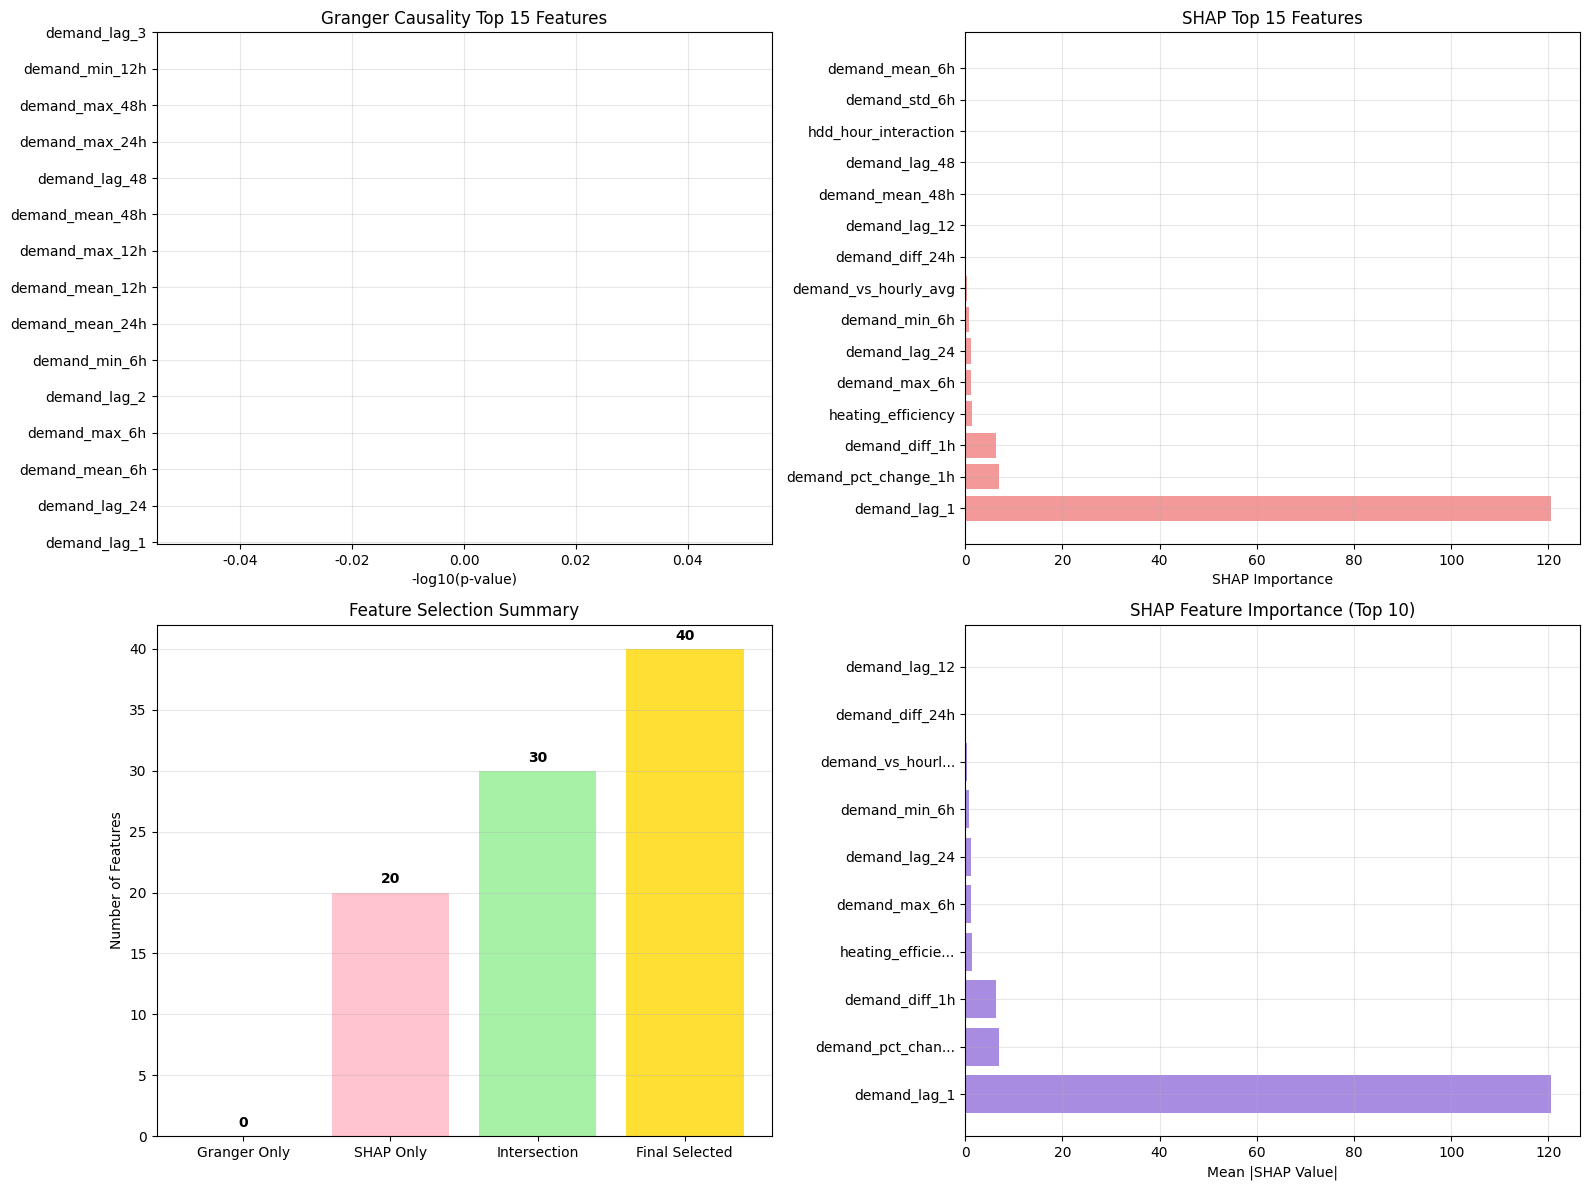


🎯 최종 선택된 특성 (40개):
    1. demand_vs_hourly_avg
    2. demand_max_12h
    3. ta_chi
    4. branch_B_hdd
    5. demand_mean_12h
    6. demand_min_24h
    7. demand_mean_24h
    8. demand_lag_3
    9. demand_lag_6
   10. discomfort_index
   11. demand_lag_48
   12. demand_std_6h
   13. demand_min_12h
   14. demand_lag_1
   15. hdd_hour_interaction
   16. ta
   17. demand_min_48h
   18. demand_std_12h
   19. demand_lag_12
   20. HDD_18
   21. demand_max_48h
   22. ta_month_interaction
   23. demand_min_6h
   24. demand_max_24h
   25. demand_mean_48h
   26. demand_std_48h
   27. demand_lag_24
   28. demand_max_6h
   29. demand_lag_2
   30. demand_mean_6h
   31. demand_pct_change_1h
   32. demand_diff_1h
   33. heating_efficiency
   34. demand_diff_24h
   35. branch_B_temp
   36. ta_hour_interaction
   37. wind_temp_interaction
   38. hm
   39. ws
   40. wd

🎉 특성 선택 분석 완료!


In [26]:
feature_results = run_feature_selection_analysis(final_train_df_new)

## DLinear

In [1]:
# 전처리된 데이터 파일 활용 DLinear 테스트
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🎯 전처리된 데이터 파일 활용 DLinear 테스트!")

# ==========================================
# 1. 선택된 특성 정의
# ==========================================

SELECTED_FEATURES = [
    'demand_vs_hourly_avg', 'demand_max_12h', 'ta_chi', 'branch_B_hdd',
    'demand_mean_12h', 'demand_min_24h', 'demand_mean_24h', 'demand_lag_3',
    'demand_lag_6', 'discomfort_index', 'demand_lag_48', 'demand_std_6h',
    'demand_min_12h', 'demand_lag_1', 'hdd_hour_interaction', 'ta',
    'demand_min_48h', 'demand_std_12h', 'demand_lag_12', 'HDD_18',
    'demand_max_48h', 'ta_month_interaction', 'demand_min_6h', 'demand_max_24h',
    'demand_mean_48h', 'demand_std_48h', 'demand_lag_24', 'demand_max_6h',
    'demand_lag_2', 'demand_mean_6h', 'demand_pct_change_1h', 'demand_diff_1h',
    'heating_efficiency', 'demand_diff_24h', 'branch_B_temp', 'ta_hour_interaction',
    'wind_temp_interaction', 'hm', 'ws', 'wd'
]

# ==========================================
# 2. 데이터 로드 함수
# ==========================================

def load_processed_data(train_path='processed_train_data.csv',
                       val_path='processed_val_data.csv', 
                       test_path='processed_test_data.csv'):
    """
    전처리된 데이터 파일들을 로드합니다.
    """
    print("📁 전처리된 데이터 로드 중...")
    
    # 데이터 로드
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    print(f"   훈련 데이터: {train_df.shape}")
    print(f"   검증 데이터: {val_df.shape}")
    print(f"   테스트 데이터: {test_df.shape}")
    
    # Unnamed 컬럼 제거
    for df in [train_df, val_df, test_df]:
        unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
        if unnamed_cols:
            df.drop(columns=unnamed_cols, inplace=True)
    
    print(f"   컬럼 예시: {list(train_df.columns)[:10]}...")
    
    return train_df, val_df, test_df

# ==========================================
# 3. 특성 선택 및 확인
# ==========================================

def select_features(train_df, val_df, test_df, selected_features, target_col='heat_demand'):
    """
    사용 가능한 특성을 확인하고 선택합니다.
    """
    print("🔍 특성 확인 및 선택...")
    
    # 모든 데이터에서 공통으로 사용 가능한 특성 찾기
    all_columns = set(train_df.columns) & set(val_df.columns) & set(test_df.columns)
    
    available_features = []
    missing_features = []
    
    for feature in selected_features:
        if feature in all_columns:
            available_features.append(feature)
        else:
            missing_features.append(feature)
    
    print(f"   ✅ 사용 가능한 특성: {len(available_features)}개")
    print(f"   ❌ 누락된 특성: {len(missing_features)}개")
    
    if missing_features:
        print(f"      누락 특성 예시: {missing_features[:5]}...")
    
    # 타겟 변수 확인
    if target_col not in all_columns:
        raise ValueError(f"타겟 변수 '{target_col}'가 모든 데이터에 없습니다.")
    
    # 특성이 부족한 경우 상관관계 기반 자동 선택
    if len(available_features) < 20:
        print("   🔄 사용 가능한 특성이 부족하여 추가 특성 선택...")
        
        # 수치형 컬럼 중에서 타겟과 상관관계 높은 특성 선택
        numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
        if target_col in numeric_cols:
            numeric_cols.remove(target_col)
        
        # 이미 선택된 특성 제외
        remaining_cols = [col for col in numeric_cols if col not in available_features]
        
        if remaining_cols:
            # 상관관계 계산
            correlations = train_df[remaining_cols].corrwith(train_df[target_col]).abs()
            additional_features = correlations.nlargest(30 - len(available_features)).index.tolist()
            available_features.extend(additional_features)
            
            print(f"   ✅ 추가 특성 선택 완료: 총 {len(available_features)}개")
    
    # 최종 특성 목록 출력
    print(f"\n📋 최종 사용 특성 ({len(available_features)}개):")
    for i, feature in enumerate(available_features[:20], 1):  # 상위 20개만 출력
        print(f"      {i:2d}. {feature}")
    if len(available_features) > 20:
        print(f"      ... 외 {len(available_features) - 20}개")
    
    return available_features

# ==========================================
# 4. 향상된 DLinear 모델
# ==========================================

class AdvancedDLinear(nn.Module):
    """
    전처리된 데이터에 최적화된 DLinear 모델
    """
    def __init__(self, seq_len, pred_len, enc_in):
        super(AdvancedDLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        
        # 특성 가중치 학습
        self.feature_weights = nn.Parameter(torch.ones(enc_in))
        
        # 다층 특성 투영
        self.feature_projection = nn.Sequential(
            nn.Linear(enc_in, enc_in // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(enc_in // 2, 1)
        )
        
        # 분해를 위한 윈도우
        self.decomp_window = min(25, seq_len // 3)
        if self.decomp_window % 2 == 0:
            self.decomp_window += 1
        
        # 추세와 계절성 레이어
        self.trend_linear = nn.Linear(seq_len, pred_len)
        self.seasonal_linear = nn.Linear(seq_len, pred_len)
        
        # 최종 조정 레이어
        self.output_projection = nn.Linear(pred_len, pred_len)
        
        # 드롭아웃
        self.dropout = nn.Dropout(0.1)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def moving_average_decomp(self, x):
        """이동평균 기반 분해"""
        batch_size, seq_len = x.shape
        window = self.decomp_window
        
        # 패딩 추가
        padding = window // 2
        x_padded = torch.nn.functional.pad(x, (padding, padding), mode='reflect')
        
        # 컨볼루션으로 이동평균
        kernel = torch.ones(1, 1, window, device=x.device) / window
        trend = torch.nn.functional.conv1d(
            x_padded.unsqueeze(1), kernel, padding=0
        ).squeeze(1)
        
        # 크기 조정
        if trend.size(1) != seq_len:
            trend = torch.nn.functional.interpolate(
                trend.unsqueeze(1), size=seq_len, mode='linear', align_corners=False
            ).squeeze(1)
        
        seasonal = x - trend
        return trend, seasonal
    
    def forward(self, x):
        # x: (batch_size, seq_len, enc_in)
        batch_size, seq_len, _ = x.shape
        
        # 특성 가중치 적용
        weighted_x = x * torch.softmax(self.feature_weights, dim=0)
        
        # 특성 투영
        x_proj = self.feature_projection(weighted_x).squeeze(-1)  # (batch_size, seq_len)
        
        # 분해
        trend, seasonal = self.moving_average_decomp(x_proj)
        
        # 드롭아웃
        trend = self.dropout(trend)
        seasonal = self.dropout(seasonal)
        
        # 선형 변환
        trend_pred = self.trend_linear(trend)
        seasonal_pred = self.seasonal_linear(seasonal)
        
        # 결합 및 최종 조정
        combined = trend_pred + seasonal_pred
        output = self.output_projection(combined)
        
        return output.unsqueeze(-1)

# ==========================================
# 5. 시퀀스 생성 함수
# ==========================================

def create_sequences_from_processed(df, features, target_col, seq_len=24, pred_len=6):
    """
    전처리된 데이터에서 시퀀스 생성
    """
    print(f"📊 시퀀스 생성: {seq_len}h → {pred_len}h")
    
    # 시간 정렬 (datetime 컬럼이 있다면)
    if 'datetime' in df.columns:
        df = df.sort_values('datetime').reset_index(drop=True)
    elif 'tm' in df.columns:
        df = df.sort_values('tm').reset_index(drop=True)
    
    # 필요한 컬럼만 추출
    data = df[features + [target_col]].copy()
    
    # 결측치 처리
    data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)
    data = data.replace([np.inf, -np.inf], 0)
    
    print(f"   데이터 크기: {len(data):,}행")
    
    # 시퀀스 생성
    X_list = []
    y_list = []
    
    max_idx = len(data) - seq_len - pred_len + 1
    
    if max_idx <= 0:
        raise ValueError(f"데이터 부족: 필요 {seq_len + pred_len}, 보유 {len(data)}")
    
    print(f"   생성 가능한 시퀀스: {max_idx:,}개")
    
    # 메모리 효율적 생성
    batch_size = 5000
    for start_idx in tqdm(range(0, max_idx, batch_size), desc="시퀀스 생성"):
        end_idx = min(start_idx + batch_size, max_idx)
        
        batch_X = []
        batch_y = []
        
        for i in range(start_idx, end_idx):
            x_seq = data[features].iloc[i:i+seq_len].values
            y_seq = data[target_col].iloc[i+seq_len:i+seq_len+pred_len].values
            
            batch_X.append(x_seq)
            batch_y.append(y_seq)
        
        X_list.extend(batch_X)
        y_list.extend(batch_y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"   ✅ 시퀀스 생성 완료: X{X.shape}, y{y.shape}")
    
    return X, y

# ==========================================
# 6. 훈련 함수
# ==========================================

def train_processed_dlinear(train_df, val_df, test_df, features, target_col='heat_demand',
                           seq_len=24, pred_len=6, epochs=100, batch_size=64, lr=0.001):
    """
    전처리된 데이터로 DLinear 훈련
    """
    print("🚀 전처리된 데이터 기반 DLinear 훈련!")
    
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   디바이스: {device}")
    
    # 시퀀스 생성
    print("\n📊 훈련 데이터 시퀀스 생성...")
    X_train, y_train = create_sequences_from_processed(train_df, features, target_col, seq_len, pred_len)
    
    print("\n📊 검증 데이터 시퀀스 생성...")
    X_val, y_val = create_sequences_from_processed(val_df, features, target_col, seq_len, pred_len)
    
    print("\n📊 테스트 데이터 시퀀스 생성...")
    X_test, y_test = create_sequences_from_processed(test_df, features, target_col, seq_len, pred_len)
    
    print(f"\n📋 최종 데이터 크기:")
    print(f"   훈련: {X_train.shape}")
    print(f"   검증: {X_val.shape}")
    print(f"   테스트: {X_test.shape}")
    
    # 정규화
    print("\n🔧 데이터 정규화...")
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # X 정규화
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train.shape)
    
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_val_scaled = scaler_X.transform(X_val_flat).reshape(X_val.shape)
    
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)
    
    # y 정규화
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    
    # 텐서 변환
    X_train_t = torch.FloatTensor(X_train_scaled).to(device)
    y_train_t = torch.FloatTensor(y_train_scaled).to(device)
    X_val_t = torch.FloatTensor(X_val_scaled).to(device)
    y_val_t = torch.FloatTensor(y_val_scaled).to(device)
    X_test_t = torch.FloatTensor(X_test_scaled).to(device)
    y_test_t = torch.FloatTensor(y_test_scaled).to(device)
    
    # 모델 초기화
    model = AdvancedDLinear(seq_len, pred_len, len(features)).to(device)
    
    # 손실함수와 옵티마이저
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # 데이터 로더
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 훈련
    print("\n🔥 모델 훈련 시작...")
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15
    no_improve = 0
    
    for epoch in tqdm(range(epochs), desc="훈련 진행"):
        # 훈련
        model.train()
        epoch_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x).squeeze(-1)
            loss = criterion(pred, batch_y)
            loss.backward()
            
            # 그래디언트 클리핑
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        # 검증
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t).squeeze(-1)
            val_loss = criterion(val_pred, y_val_t).item()
        
        # 기록
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        # 학습률 스케줄링
        scheduler.step()
        
        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"\n   ⏰ 조기 종료 (epoch {epoch+1})")
                break
        
        # 진행상황 출력
        if (epoch + 1) % 20 == 0:
            lr_current = optimizer.param_groups[0]['lr']
            print(f"\n   Epoch {epoch+1:3d}: Train={avg_train_loss:.6f}, Val={val_loss:.6f}, LR={lr_current:.6f}")
    
    # 최적 모델 복원
    model.load_state_dict(best_model_state)
    print("\n   ✅ 훈련 완료!")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'test_data': (X_test_t, y_test_t, X_test, y_test),
        'val_data': (X_val_t, y_val_t, X_val, y_val),
        'device': device
    }

# ==========================================
# 7. 평가 및 시각화
# ==========================================

def evaluate_processed_results(results, features_used):
    """
    결과 평가 및 시각화
    """
    print("\n📊 성능 평가 및 시각화...")
    
    model = results['model']
    scaler_y = results['scaler_y']
    X_test_t, y_test_t, X_test_orig, y_test_orig = results['test_data']
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    
    # 테스트 예측
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t).squeeze(-1).cpu().numpy()
    
    # 역정규화
    test_pred_orig = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).reshape(test_pred.shape)
    
    # 성능 지표 계산
    mae = mean_absolute_error(y_test_orig.flatten(), test_pred_orig.flatten())
    mse = mean_squared_error(y_test_orig.flatten(), test_pred_orig.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig.flatten(), test_pred_orig.flatten())
    
    # MAPE 계산
    non_zero_mask = y_test_orig.flatten() != 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((y_test_orig.flatten()[non_zero_mask] - test_pred_orig.flatten()[non_zero_mask]) / 
                            y_test_orig.flatten()[non_zero_mask])) * 100
    else:
        mape = 0
    
    print(f"\n📈 최종 성능 지표:")
    print(f"   MAE:  {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   사용된 특성: {len(features_used)}개")
    print(f"   테스트 샘플: {len(test_pred_orig.flatten()):,}개")
    
    # 시각화
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('DLinear Performance with Processed Data', fontsize=16, fontweight='bold')
    
    # 1. 훈련 손실
    axes[0, 0].plot(train_losses, label='Train Loss', color='blue', alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', alpha=0.8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 예측 vs 실제 (다중 샘플)
    axes[0, 1].set_title('Prediction vs Actual (Multiple Samples)')
    n_samples = min(10, len(test_pred_orig))
    for i in range(n_samples):
        idx = np.random.randint(0, len(test_pred_orig))
        alpha = 0.8 if i < 3 else 0.3
        if i == 0:
            axes[0, 1].plot(y_test_orig[idx], 'o-', label='Actual', alpha=alpha, markersize=2)
            axes[0, 1].plot(test_pred_orig[idx], 's-', label='Predicted', alpha=alpha, markersize=2)
        else:
            axes[0, 1].plot(y_test_orig[idx], 'o-', alpha=alpha, markersize=1, color='green')
            axes[0, 1].plot(test_pred_orig[idx], 's-', alpha=alpha, markersize=1, color='orange')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Heat Demand')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 산점도
    sample_size = min(10000, len(test_pred_orig.flatten()))
    sample_idx = np.random.choice(len(test_pred_orig.flatten()), sample_size, replace=False)
    y_sample = y_test_orig.flatten()[sample_idx]
    pred_sample = test_pred_orig.flatten()[sample_idx]
    
    axes[0, 2].scatter(y_sample, pred_sample, alpha=0.3, s=1)
    min_val = min(y_sample.min(), pred_sample.min())
    max_val = max(y_sample.max(), pred_sample.max())
    axes[0, 2].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[0, 2].set_xlabel('Actual')
    axes[0, 2].set_ylabel('Predicted')
    axes[0, 2].set_title(f'Scatter Plot (n={sample_size:,})')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. 잔차 분포
    residuals = y_sample - pred_sample
    axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.8)
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Residual Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. 시계열 추세
    start_idx = len(test_pred_orig) // 2
    end_idx = min(start_idx + 200, len(test_pred_orig))
    time_range = range(end_idx - start_idx)
    
    axes[1, 1].plot(time_range, y_test_orig[start_idx:end_idx, 0], 
                   label='Actual', alpha=0.8, linewidth=1)
    axes[1, 1].plot(time_range, test_pred_orig[start_idx:end_idx, 0], 
                   label='Predicted', alpha=0.8, linewidth=1)
    axes[1, 1].set_xlabel('Time Sequence')
    axes[1, 1].set_ylabel('Heat Demand')
    axes[1, 1].set_title('Time Series Pattern')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. 성능 지표 시각화
    metrics = ['MAE', 'RMSE', 'R²', 'MAPE(%)']
    values = [mae, rmse, r2, mape]
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold']
    
    bars = axes[1, 2].bar(metrics, values, color=colors, alpha=0.8)
    axes[1, 2].set_title('Performance Metrics')
    axes[1, 2].set_ylabel('Value')
    
    for bar, value in zip(bars, values):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, 
                       bar.get_height() + bar.get_height()*0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape,
        'predictions': test_pred_orig, 'actual': y_test_orig
    }

# ==========================================
# 8. 메인 실행 함수
# ==========================================

def run_processed_dlinear_test(selected_features=None, 
                              train_path='processed_train_data.csv',
                              val_path='processed_val_data.csv',
                              test_path='processed_test_data.csv'):
    """
    전처리된 데이터로 DLinear 테스트 실행
    """
    if selected_features is None:
        selected_features = SELECTED_FEATURES
    
    print("🎯 전처리된 데이터 기반 DLinear 테스트 시작!")
    print("="*70)
    
    # 1. 데이터 로드
    train_df, val_df, test_df = load_processed_data(train_path, val_path, test_path)
    
    # 2. 특성 선택
    features_used = select_features(train_df, val_df, test_df, selected_features)
    
    # 3. 모델 훈련
    print("\n" + "="*50)
    results = train_processed_dlinear(
        train_df, val_df, test_df, features_used,
        seq_len=24, pred_len=6, epochs=100,
        batch_size=64, lr=0.001
    )
    
    # 4. 결과 평가
    print("\n" + "="*50)
    eval_results = evaluate_processed_results(results, features_used)
    
    print("\n🎉 전처리된 데이터 기반 DLinear 테스트 완료!")
    
    return {
        'training_results': results,
        'evaluation': eval_results,
        'features_used': features_used
    }

# ==========================================
# 9. 간단 실행 함수
# ==========================================

def quick_processed_test():
    """
    전처리된 데이터로 빠른 테스트
    """
    print("⚡ 빠른 전처리 데이터 테스트!")
    
    # 핵심 특성만 사용 (빠른 실행용)
    core_features = [
        'ta', 'HDD_18', 'hour', 'month', 'heating_season',
        'demand_lag_1', 'demand_lag_24', 'demand_mean_24h',
        'ta_hour_interaction', 'hdd_hour_interaction'
    ]
    
    return run_processed_dlinear_test(
        selected_features=core_features,
        train_path='processed_train_data.csv',
        val_path='processed_val_data.csv', 
        test_path='processed_test_data.csv'
    )

# ==========================================
# 실행 예시
# ==========================================

print("\n📋 실행 방법:")
print("# 1. 전체 40개 특성으로 실행")
print("results = run_processed_dlinear_test()")
print()
print("# 2. 빠른 테스트 (핵심 특성만)")
print("results = quick_processed_test()")
print()
print("# 3. 커스텀 특성으로 실행")
print("my_features = ['ta', 'HDD_18', 'hour', 'demand_lag_1', ...]")
print("results = run_processed_dlinear_test(selected_features=my_features)")
print()
print("# 4. 다른 파일 경로 지정")
print("results = run_processed_dlinear_test(")
print("    train_path='my_train.csv',")
print("    val_path='my_val.csv',")
print("    test_path='my_test.csv'")
print(")")

print("\n🎯 권장 실행:")
print("results = run_processed_dlinear_test()  # 전체 특성")
print("# 또는")
print("results = quick_processed_test()        # 빠른 테스트")

🎯 전처리된 데이터 파일 활용 DLinear 테스트!

📋 실행 방법:
# 1. 전체 40개 특성으로 실행
results = run_processed_dlinear_test()

# 2. 빠른 테스트 (핵심 특성만)
results = quick_processed_test()

# 3. 커스텀 특성으로 실행
my_features = ['ta', 'HDD_18', 'hour', 'demand_lag_1', ...]
results = run_processed_dlinear_test(selected_features=my_features)

# 4. 다른 파일 경로 지정
results = run_processed_dlinear_test(
    train_path='my_train.csv',
    val_path='my_val.csv',
    test_path='my_test.csv'
)

🎯 권장 실행:
results = run_processed_dlinear_test()  # 전체 특성
# 또는
results = quick_processed_test()        # 빠른 테스트


In [2]:
results = run_processed_dlinear_test() 

🎯 전처리된 데이터 기반 DLinear 테스트 시작!
📁 전처리된 데이터 로드 중...
   훈련 데이터: (21022, 117)
   검증 데이터: (5255, 117)
   테스트 데이터: (26280, 117)
   컬럼 예시: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'hour', 'month']...
🔍 특성 확인 및 선택...
   ✅ 사용 가능한 특성: 40개
   ❌ 누락된 특성: 0개

📋 최종 사용 특성 (40개):
       1. demand_vs_hourly_avg
       2. demand_max_12h
       3. ta_chi
       4. branch_B_hdd
       5. demand_mean_12h
       6. demand_min_24h
       7. demand_mean_24h
       8. demand_lag_3
       9. demand_lag_6
      10. discomfort_index
      11. demand_lag_48
      12. demand_std_6h
      13. demand_min_12h
      14. demand_lag_1
      15. hdd_hour_interaction
      16. ta
      17. demand_min_48h
      18. demand_std_12h
      19. demand_lag_12
      20. HDD_18
      ... 외 20개

🚀 전처리된 데이터 기반 DLinear 훈련!
   디바이스: cpu

📊 훈련 데이터 시퀀스 생성...
📊 시퀀스 생성: 24h → 6h
   데이터 크기: 21,022행
   생성 가능한 시퀀스: 20,993개


시퀀스 생성:  40%|████      | 2/5 [00:20<00:31, 10.50s/it]

: 

In [1]:
# 메모리 효율적인 경량화 DLinear
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

print("⚡ 메모리 효율적인 경량화 DLinear!")

# ==========================================
# 1. 경량화 DLinear 모델
# ==========================================

class LightDLinear(nn.Module):
    """
    메모리 효율적인 경량 DLinear
    """
    def __init__(self, seq_len, pred_len, enc_in):
        super(LightDLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # 간단한 특성 투영
        self.feature_projection = nn.Linear(enc_in, 1)
        
        # 직접 매핑 (분해 없이)
        self.direct_linear = nn.Linear(seq_len, pred_len)
        
        # 드롭아웃
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # x: (batch_size, seq_len, enc_in)
        x_proj = self.feature_projection(x).squeeze(-1)  # (batch_size, seq_len)
        x_proj = self.dropout(x_proj)
        output = self.direct_linear(x_proj)  # (batch_size, pred_len)
        return output.unsqueeze(-1)

# ==========================================
# 2. 메모리 효율적 데이터 로더
# ==========================================

def load_sample_data(file_path, sample_ratio=0.3, random_state=42):
    """
    메모리 절약을 위해 데이터 샘플링
    """
    print(f"📁 샘플 데이터 로드: {file_path} (샘플 비율: {sample_ratio})")
    
    # 전체 데이터 크기 확인
    df_full = pd.read_csv(file_path)
    total_rows = len(df_full)
    sample_size = int(total_rows * sample_ratio)
    
    print(f"   전체: {total_rows:,}행 → 샘플: {sample_size:,}행")
    
    # 랜덤 샘플링
    np.random.seed(random_state)
    sample_indices = np.random.choice(total_rows, sample_size, replace=False)
    sample_indices = np.sort(sample_indices)  # 시간 순서 유지
    
    df_sample = df_full.iloc[sample_indices].reset_index(drop=True)
    
    # 메모리 정리
    del df_full
    gc.collect()
    
    # Unnamed 컬럼 제거
    unnamed_cols = [col for col in df_sample.columns if 'Unnamed' in col]
    if unnamed_cols:
        df_sample.drop(columns=unnamed_cols, inplace=True)
    
    return df_sample

# ==========================================
# 3. 빠른 시퀀스 생성
# ==========================================

def create_sequences_fast(df, features, target_col, seq_len=24, pred_len=6, step=5):
    """
    메모리 효율적인 빠른 시퀀스 생성
    """
    print(f"📊 빠른 시퀀스 생성: {seq_len}→{pred_len}, step={step}")
    
    # 시간 정렬
    if 'datetime' in df.columns:
        df = df.sort_values('datetime').reset_index(drop=True)
    elif 'tm' in df.columns:
        df = df.sort_values('tm').reset_index(drop=True)
    
    # 필요한 컬럼만
    data = df[features + [target_col]].copy()
    data = data.fillna(method='ffill').fillna(0)
    
    print(f"   데이터 크기: {len(data):,}행")
    
    # step만큼 건너뛰면서 시퀀스 생성
    X_list = []
    y_list = []
    
    max_idx = len(data) - seq_len - pred_len + 1
    
    for i in range(0, max_idx, step):
        x_seq = data[features].iloc[i:i+seq_len].values
        y_seq = data[target_col].iloc[i+seq_len:i+seq_len+pred_len].values
        
        X_list.append(x_seq)
        y_list.append(y_seq)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"   ✅ 시퀀스 완료: X{X.shape}, y{y.shape}")
    
    return X, y

# ==========================================
# 4. 경량화 훈련 함수
# ==========================================

def train_light_dlinear(train_df, val_df, test_df, features, target_col='heat_demand',
                        epochs=30, batch_size=32, lr=0.001):
    """
    경량화 DLinear 훈련
    """
    print("🚀 경량화 DLinear 훈련 시작!")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   디바이스: {device}")
    
    # 시퀀스 생성 (step 크게 해서 메모리 절약)
    X_train, y_train = create_sequences_fast(train_df, features, target_col, step=10)
    X_val, y_val = create_sequences_fast(val_df, features, target_col, step=10)
    X_test, y_test = create_sequences_fast(test_df, features, target_col, step=10)
    
    print(f"\n📋 시퀀스 크기:")
    print(f"   훈련: {X_train.shape}")
    print(f"   검증: {X_val.shape}")
    print(f"   테스트: {X_test.shape}")
    
    # 정규화
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # 배치 단위로 정규화 (메모리 절약)
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train.shape)
    del X_train_flat
    
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_val_scaled = scaler_X.transform(X_val_flat).reshape(X_val.shape)
    del X_val_flat
    
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)
    del X_test_flat
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    
    # 메모리 정리
    gc.collect()
    
    # 텐서 변환
    X_train_t = torch.FloatTensor(X_train_scaled).to(device)
    y_train_t = torch.FloatTensor(y_train_scaled).to(device)
    X_val_t = torch.FloatTensor(X_val_scaled).to(device)
    y_val_t = torch.FloatTensor(y_val_scaled).to(device)
    X_test_t = torch.FloatTensor(X_test_scaled).to(device)
    y_test_t = torch.FloatTensor(y_test_scaled).to(device)
    
    # 모델
    model = LightDLinear(24, 6, len(features)).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 데이터 로더
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 훈련
    print("\n🔥 훈련 시작...")
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs), desc="훈련"):
        # 훈련
        model.train()
        epoch_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x).squeeze(-1)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # 검증
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t).squeeze(-1)
            val_loss = criterion(val_pred, y_val_t).item()
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1}: Train={train_losses[-1]:.6f}, Val={val_loss:.6f}")
    
    print("   ✅ 훈련 완료!")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'scaler_y': scaler_y,
        'test_data': (X_test_t, y_test_t, X_test, y_test),
        'device': device
    }

# ==========================================
# 5. 빠른 평가
# ==========================================

def evaluate_light_results(results, features_used):
    """
    경량화 결과 평가
    """
    print("\n📊 성능 평가...")
    
    model = results['model']
    scaler_y = results['scaler_y']
    X_test_t, y_test_t, X_test_orig, y_test_orig = results['test_data']
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    
    # 예측
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t).squeeze(-1).cpu().numpy()
    
    # 역정규화
    test_pred_orig = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).reshape(test_pred.shape)
    
    # 성능 지표
    mae = mean_absolute_error(y_test_orig.flatten(), test_pred_orig.flatten())
    rmse = np.sqrt(mean_squared_error(y_test_orig.flatten(), test_pred_orig.flatten()))
    r2 = r2_score(y_test_orig.flatten(), test_pred_orig.flatten())
    
    # MAPE
    non_zero_mask = y_test_orig.flatten() != 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((y_test_orig.flatten()[non_zero_mask] - test_pred_orig.flatten()[non_zero_mask]) / 
                            y_test_orig.flatten()[non_zero_mask])) * 100
    else:
        mape = 0
    
    print(f"\n📈 성능 지표:")
    print(f"   MAE:  {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   특성 수: {len(features_used)}")
    print(f"   테스트 샘플: {len(test_pred_orig.flatten()):,}")
    
    # 간단한 시각화
    plt.figure(figsize=(15, 4))
    
    # 1. 손실
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 예측 vs 실제
    plt.subplot(1, 3, 2)
    sample_idx = np.random.randint(0, len(test_pred_orig))
    plt.plot(y_test_orig[sample_idx], 'o-', label='Actual', markersize=4)
    plt.plot(test_pred_orig[sample_idx], 's-', label='Predicted', markersize=4)
    plt.xlabel('Time Step')
    plt.ylabel('Heat Demand')
    plt.title('Sample Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 산점도
    plt.subplot(1, 3, 3)
    sample_size = min(2000, len(test_pred_orig.flatten()))
    sample_idx = np.random.choice(len(test_pred_orig.flatten()), sample_size, replace=False)
    y_sample = y_test_orig.flatten()[sample_idx]
    pred_sample = test_pred_orig.flatten()[sample_idx]
    
    plt.scatter(y_sample, pred_sample, alpha=0.5, s=10)
    min_val = min(y_sample.min(), pred_sample.min())
    max_val = max(y_sample.max(), pred_sample.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape,
        'predictions': test_pred_orig, 'actual': y_test_orig
    }

# ==========================================
# 6. 메인 실행 함수
# ==========================================

def run_lightweight_test(sample_ratio=0.2, selected_features=None):
    """
    경량화 DLinear 테스트 실행
    """
    print("⚡ 경량화 DLinear 테스트 시작!")
    print("="*50)
    
    # 기본 특성 설정
    if selected_features is None:
        selected_features = [
            'ta', 'hm', 'ws', 'HDD_18', 'hour', 'month', 'dayofweek',
            'heating_season', 'is_weekend', 'discomfort_index'
        ]
    
    print(f"   샘플 비율: {sample_ratio}")
    print(f"   사용 특성: {len(selected_features)}개")
    
    try:
        # 데이터 로드 (샘플링)
        train_df = load_sample_data('processed_train_data.csv', sample_ratio)
        val_df = load_sample_data('processed_val_data.csv', sample_ratio)
        test_df = load_sample_data('processed_test_data.csv', sample_ratio)
        
        # 사용 가능한 특성 필터링
        available_features = []
        for feature in selected_features:
            if (feature in train_df.columns and 
                feature in val_df.columns and 
                feature in test_df.columns):
                available_features.append(feature)
        
        print(f"   실제 사용 특성: {len(available_features)}개")
        print(f"   특성 목록: {available_features}")
        
        if len(available_features) < 5:
            # 기본 특성으로 대체
            basic_features = ['ta', 'hm', 'hour', 'month']
            available_features = [f for f in basic_features if f in train_df.columns]
            print(f"   기본 특성으로 대체: {available_features}")
        
        if 'heat_demand' not in train_df.columns:
            raise ValueError("타겟 변수 'heat_demand'가 없습니다.")
        
        # 훈련
        results = train_light_dlinear(
            train_df, val_df, test_df, available_features,
            epochs=30, batch_size=32, lr=0.001
        )
        
        # 평가
        eval_results = evaluate_light_results(results, available_features)
        
        print("\n⚡ 경량화 테스트 완료!")
        
        return {
            'training_results': results,
            'evaluation': eval_results,
            'features_used': available_features
        }
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("\n🔧 해결 방법:")
        print("1. 파일 경로 확인: processed_train_data.csv 등이 있는지 확인")
        print("2. 샘플 비율 줄이기: sample_ratio=0.1로 시도")
        print("3. 특성 수 줄이기: 기본 특성만 사용")
        
        return None

# ==========================================
# 7. 초간단 테스트
# ==========================================

def ultra_simple_test():
    """
    최소한의 리소스로 테스트
    """
    print("🔥 초간단 테스트!")
    
    basic_features = ['ta', 'hour', 'month']
    
    return run_lightweight_test(
        sample_ratio=0.1,  # 10%만 사용
        selected_features=basic_features
    )

# ==========================================
# 실행 가이드
# ==========================================

print("\n📋 실행 방법 (메모리 안전):")
print("# 1. 초간단 테스트 (가장 안전)")
print("results = ultra_simple_test()")
print()
print("# 2. 경량화 테스트")
print("results = run_lightweight_test(sample_ratio=0.2)")
print()
print("# 3. 커스텀 설정")
print("my_features = ['ta', 'HDD_18', 'hour', 'heating_season']")
print("results = run_lightweight_test(sample_ratio=0.3, selected_features=my_features)")

print("\n⚡ 권장 첫 실행:")
print("results = ultra_simple_test()")
print("# 문제없으면 점차 sample_ratio와 특성 수 늘려가기")

⚡ 메모리 효율적인 경량화 DLinear!

📋 실행 방법 (메모리 안전):
# 1. 초간단 테스트 (가장 안전)
results = ultra_simple_test()

# 2. 경량화 테스트
results = run_lightweight_test(sample_ratio=0.2)

# 3. 커스텀 설정
my_features = ['ta', 'HDD_18', 'hour', 'heating_season']
results = run_lightweight_test(sample_ratio=0.3, selected_features=my_features)

⚡ 권장 첫 실행:
results = ultra_simple_test()
# 문제없으면 점차 sample_ratio와 특성 수 늘려가기


🔥 초간단 테스트!
⚡ 경량화 DLinear 테스트 시작!
   샘플 비율: 0.1
   사용 특성: 3개
📁 샘플 데이터 로드: processed_train_data.csv (샘플 비율: 0.1)
   전체: 21,022행 → 샘플: 2,102행
📁 샘플 데이터 로드: processed_val_data.csv (샘플 비율: 0.1)
   전체: 5,255행 → 샘플: 525행
📁 샘플 데이터 로드: processed_test_data.csv (샘플 비율: 0.1)
   전체: 26,280행 → 샘플: 2,628행
   실제 사용 특성: 3개
   특성 목록: ['ta', 'hour', 'month']
   기본 특성으로 대체: ['ta', 'hm', 'hour', 'month']
🚀 경량화 DLinear 훈련 시작!
   디바이스: cpu
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 2,102행
   ✅ 시퀀스 완료: X(208, 24, 4), y(208, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 525행
   ✅ 시퀀스 완료: X(50, 24, 4), y(50, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 2,628행
   ✅ 시퀀스 완료: X(260, 24, 4), y(260, 6)

📋 시퀀스 크기:
   훈련: (208, 24, 4)
   검증: (50, 24, 4)
   테스트: (260, 24, 4)


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)



🔥 훈련 시작...


훈련: 100%|██████████| 30/30 [00:00<00:00, 216.62it/s]

   Epoch 10: Train=0.834144, Val=0.716662
   Epoch 20: Train=0.696595, Val=0.587975
   Epoch 30: Train=0.539912, Val=0.377032
   ✅ 훈련 완료!

📊 성능 평가...

📈 성능 지표:
   MAE:  78.7475
   RMSE: 113.6413
   R²:   0.4921
   MAPE: 79.97%
   특성 수: 4
   테스트 샘플: 1,560


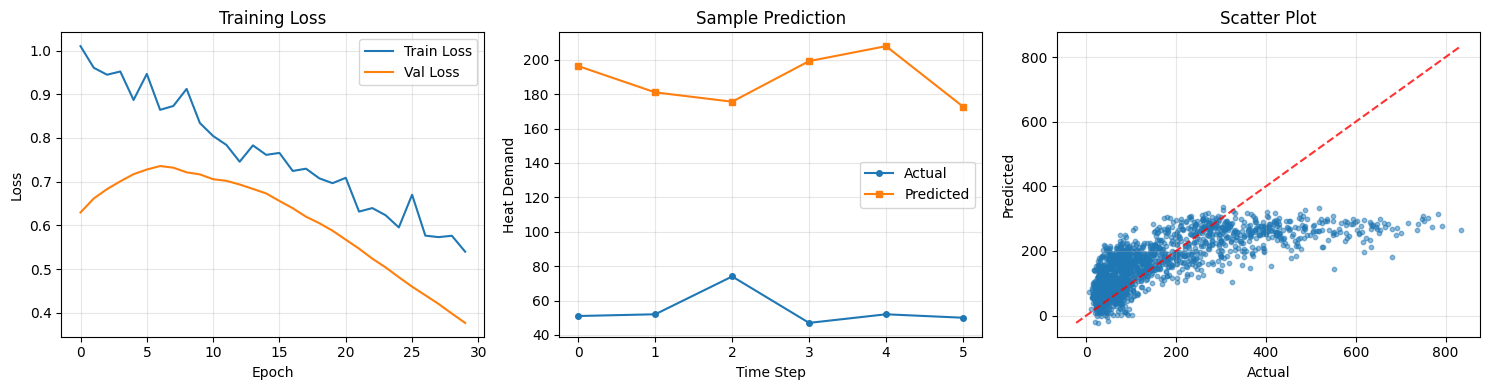


⚡ 경량화 테스트 완료!


In [2]:
results = ultra_simple_test()


⚡ 경량화 DLinear 테스트 시작!
   샘플 비율: 0.2
   사용 특성: 10개
📁 샘플 데이터 로드: processed_train_data.csv (샘플 비율: 0.2)
   전체: 21,022행 → 샘플: 4,204행
📁 샘플 데이터 로드: processed_val_data.csv (샘플 비율: 0.2)
   전체: 5,255행 → 샘플: 1,051행
📁 샘플 데이터 로드: processed_test_data.csv (샘플 비율: 0.2)
   전체: 26,280행 → 샘플: 5,256행
   실제 사용 특성: 10개
   특성 목록: ['ta', 'hm', 'ws', 'HDD_18', 'hour', 'month', 'dayofweek', 'heating_season', 'is_weekend', 'discomfort_index']
🚀 경량화 DLinear 훈련 시작!
   디바이스: cpu
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 4,204행
   ✅ 시퀀스 완료: X(418, 24, 10), y(418, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 1,051행
   ✅ 시퀀스 완료: X(103, 24, 10), y(103, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 5,256행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(523, 24, 10), y(523, 6)

📋 시퀀스 크기:
   훈련: (418, 24, 10)
   검증: (103, 24, 10)
   테스트: (523, 24, 10)

🔥 훈련 시작...


훈련:  63%|██████▎   | 19/30 [00:00<00:00, 185.24it/s]

   Epoch 10: Train=0.567563, Val=0.128653
   Epoch 20: Train=0.372111, Val=0.096148


훈련: 100%|██████████| 30/30 [00:00<00:00, 181.87it/s]


   Epoch 30: Train=0.345441, Val=0.099186
   ✅ 훈련 완료!

📊 성능 평가...

📈 성능 지표:
   MAE:  61.3938
   RMSE: 87.9384
   R²:   0.6960
   MAPE: 53.81%
   특성 수: 10
   테스트 샘플: 3,138


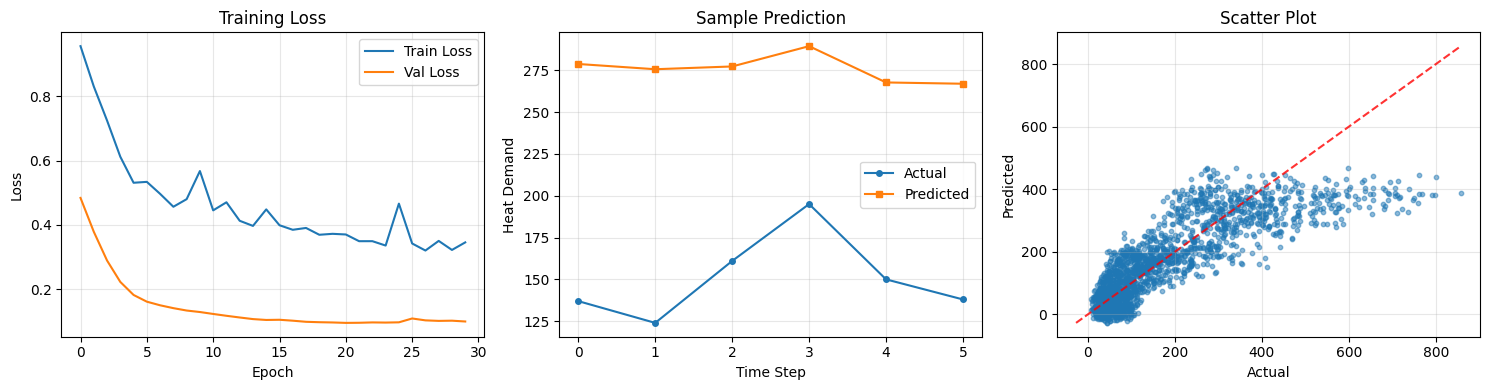


⚡ 경량화 테스트 완료!


In [3]:
results = run_lightweight_test(sample_ratio=0.2)

⚡ 경량화 DLinear 테스트 시작!
   샘플 비율: 0.5
   사용 특성: 10개
📁 샘플 데이터 로드: processed_train_data.csv (샘플 비율: 0.5)
   전체: 21,022행 → 샘플: 10,511행
📁 샘플 데이터 로드: processed_val_data.csv (샘플 비율: 0.5)
   전체: 5,255행 → 샘플: 2,627행
📁 샘플 데이터 로드: processed_test_data.csv (샘플 비율: 0.5)
   전체: 26,280행 → 샘플: 13,140행
   실제 사용 특성: 10개
   특성 목록: ['ta', 'hm', 'ws', 'HDD_18', 'hour', 'month', 'dayofweek', 'heating_season', 'is_weekend', 'discomfort_index']
🚀 경량화 DLinear 훈련 시작!
   디바이스: cpu
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 10,511행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(1049, 24, 10), y(1049, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 2,627행
   ✅ 시퀀스 완료: X(260, 24, 10), y(260, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 13,140행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(1312, 24, 10), y(1312, 6)

📋 시퀀스 크기:
   훈련: (1049, 24, 10)
   검증: (260, 24, 10)
   테스트: (1312, 24, 10)

🔥 훈련 시작...


훈련:  67%|██████▋   | 20/30 [00:00<00:00, 67.10it/s]

   Epoch 10: Train=0.324354, Val=0.135142
   Epoch 20: Train=0.309518, Val=0.146986


훈련: 100%|██████████| 30/30 [00:00<00:00, 67.30it/s]


   Epoch 30: Train=0.302114, Val=0.150086
   ✅ 훈련 완료!

📊 성능 평가...

📈 성능 지표:
   MAE:  59.1754
   RMSE: 85.1058
   R²:   0.7129
   MAPE: 48.87%
   특성 수: 10
   테스트 샘플: 7,872


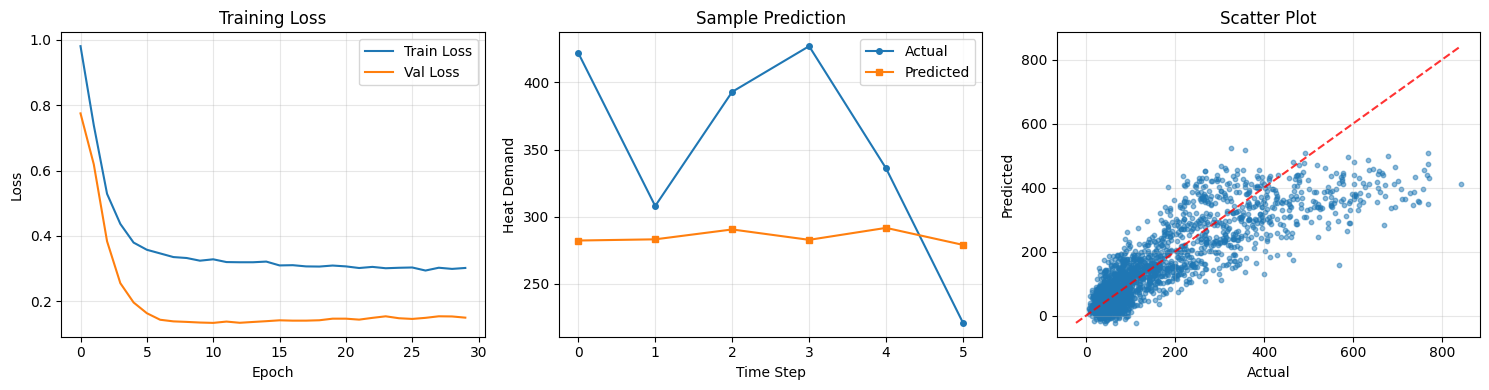


⚡ 경량화 테스트 완료!


In [4]:
results = run_lightweight_test(sample_ratio=0.5)

⚡ 경량화 DLinear 테스트 시작!
   샘플 비율: 0.7
   사용 특성: 10개
📁 샘플 데이터 로드: processed_train_data.csv (샘플 비율: 0.7)
   전체: 21,022행 → 샘플: 14,715행
📁 샘플 데이터 로드: processed_val_data.csv (샘플 비율: 0.7)
   전체: 5,255행 → 샘플: 3,678행
📁 샘플 데이터 로드: processed_test_data.csv (샘플 비율: 0.7)
   전체: 26,280행 → 샘플: 18,396행
   실제 사용 특성: 10개
   특성 목록: ['ta', 'hm', 'ws', 'HDD_18', 'hour', 'month', 'dayofweek', 'heating_season', 'is_weekend', 'discomfort_index']
🚀 경량화 DLinear 훈련 시작!
   디바이스: cpu
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 14,715행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(1469, 24, 10), y(1469, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 3,678행
   ✅ 시퀀스 완료: X(365, 24, 10), y(365, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 18,396행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(1837, 24, 10), y(1837, 6)

📋 시퀀스 크기:
   훈련: (1469, 24, 10)
   검증: (365, 24, 10)
   테스트: (1837, 24, 10)

🔥 훈련 시작...


훈련:  60%|██████    | 18/30 [00:00<00:00, 54.54it/s]

   Epoch 10: Train=0.371921, Val=0.113751
   Epoch 20: Train=0.317470, Val=0.125949


훈련: 100%|██████████| 30/30 [00:00<00:00, 54.51it/s]


   Epoch 30: Train=0.303193, Val=0.142586
   ✅ 훈련 완료!

📊 성능 평가...

📈 성능 지표:
   MAE:  59.1204
   RMSE: 84.2511
   R²:   0.7198
   MAPE: 50.39%
   특성 수: 10
   테스트 샘플: 11,022


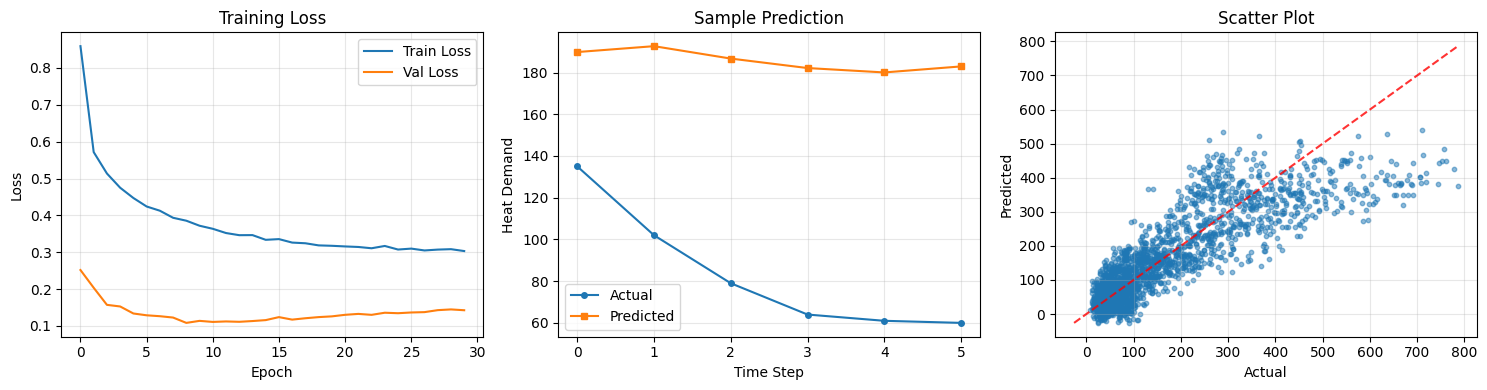


⚡ 경량화 테스트 완료!


In [5]:
results = run_lightweight_test(sample_ratio=0.7)

⚡ 경량화 DLinear 테스트 시작!
   샘플 비율: 1
   사용 특성: 10개
📁 샘플 데이터 로드: processed_train_data.csv (샘플 비율: 1)
   전체: 21,022행 → 샘플: 21,022행
📁 샘플 데이터 로드: processed_val_data.csv (샘플 비율: 1)
   전체: 5,255행 → 샘플: 5,255행
📁 샘플 데이터 로드: processed_test_data.csv (샘플 비율: 1)
   전체: 26,280행 → 샘플: 26,280행
   실제 사용 특성: 10개
   특성 목록: ['ta', 'hm', 'ws', 'HDD_18', 'hour', 'month', 'dayofweek', 'heating_season', 'is_weekend', 'discomfort_index']
🚀 경량화 DLinear 훈련 시작!
   디바이스: cpu
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 21,022행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(2100, 24, 10), y(2100, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 5,255행
   ✅ 시퀀스 완료: X(523, 24, 10), y(523, 6)
📊 빠른 시퀀스 생성: 24→6, step=10
   데이터 크기: 26,280행


/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)
/var/folders/pt/8357krnj4tv48kdjx9mrhd3r0000gp/T/ipykernel_38639/3016362846.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(0)


   ✅ 시퀀스 완료: X(2626, 24, 10), y(2626, 6)

📋 시퀀스 크기:
   훈련: (2100, 24, 10)
   검증: (523, 24, 10)
   테스트: (2626, 24, 10)

🔥 훈련 시작...


훈련:  57%|█████▋    | 17/30 [00:00<00:00, 38.86it/s]

   Epoch 10: Train=0.311477, Val=0.121154


훈련:  83%|████████▎ | 25/30 [00:00<00:00, 37.60it/s]

   Epoch 20: Train=0.274857, Val=0.138534


훈련: 100%|██████████| 30/30 [00:00<00:00, 37.82it/s]


   Epoch 30: Train=0.255067, Val=0.149509
   ✅ 훈련 완료!

📊 성능 평가...

📈 성능 지표:
   MAE:  59.2269
   RMSE: 81.8887
   R²:   0.7342
   MAPE: 56.60%
   특성 수: 10
   테스트 샘플: 15,756


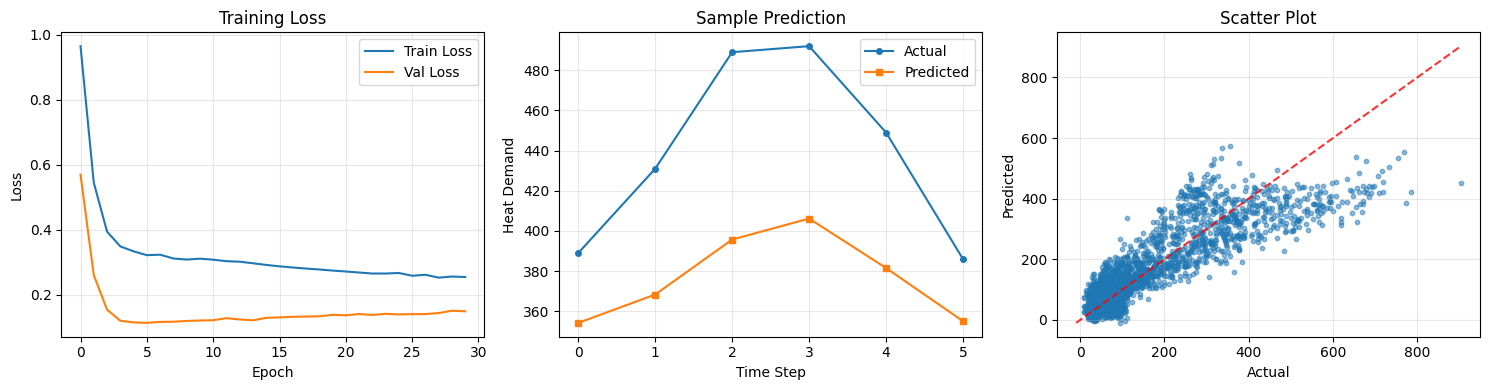


⚡ 경량화 테스트 완료!


In [6]:
results = run_lightweight_test(sample_ratio=1)

## V3
- 난방 시즌 / 비시즌 분리 DLinear

In [16]:
# 시즌별 DLinear 모델 (난방시즌 vs 비난방시즌)
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🌡️ 시즌별 DLinear 모델 (난방 vs 비난방)!")

# ==========================================
# 1. 시즌 정의 및 데이터 분할
# ==========================================

def split_by_season(df, date_col=None):
    """
    데이터를 난방시즌과 비난방시즌으로 분할
    """
    print("🌤️ 시즌별 데이터 분할...")
    
    # 사용 가능한 컬럼 확인
    print(f"   데이터 컬럼: {list(df.columns)[:10]}...")
    
    # 월 정보 찾기 또는 생성
    if 'month' in df.columns:
        # 이미 month 컬럼이 있는 경우
        print("   기존 month 컬럼 사용")
        month_col = df['month']
    elif 'tm' in df.columns:
        # tm 컬럼에서 월 추출
        print("   tm 컬럼에서 월 추출")
        df['datetime'] = pd.to_datetime(df['tm'].astype(str), format='%Y%m%d%H', errors='coerce')
        month_col = df['datetime'].dt.month
        df['month'] = month_col
    elif 'datetime' in df.columns:
        # datetime 컬럼에서 월 추출
        print("   datetime 컬럼에서 월 추출")
        df['datetime'] = pd.to_datetime(df['datetime'])
        month_col = df['datetime'].dt.month
        df['month'] = month_col
    else:
        # 월 정보가 없는 경우 - 인덱스 기반으로 추정
        print("   ⚠️ 날짜 정보 없음. 데이터 순서로 시즌 추정...")
        
        # 데이터를 12개월로 나누어 시즌 할당 (임시 방법)
        total_rows = len(df)
        rows_per_month = total_rows // 12
        
        # 월 할당 (1~12 순환)
        month_assignments = []
        for i in range(total_rows):
            month = (i // rows_per_month) % 12 + 1
            month_assignments.append(month)
        
        df['month'] = month_assignments
        month_col = df['month']
        print(f"   데이터 순서 기반 월 할당 완료 (총 {total_rows}행)")
    
    # 시즌 분할
    heating_months = [10, 11, 12, 1, 2, 3, 4]  # 난방시즌
    non_heating_months = [5, 6, 7, 8, 9]       # 비난방시즌
    
    heating_mask = month_col.isin(heating_months)
    non_heating_mask = month_col.isin(non_heating_months)
    
    heating_df = df[heating_mask].copy()
    non_heating_df = df[non_heating_mask].copy()
    
    # 월별 분포 확인
    heating_dist = heating_df['month'].value_counts().sort_index().to_dict()
    non_heating_dist = non_heating_df['month'].value_counts().sort_index().to_dict()
    
    print(f"   🔥 난방시즌 데이터: {len(heating_df):,}행 {heating_dist}")
    print(f"   ☀️ 비난방시즌 데이터: {len(non_heating_df):,}행 {non_heating_dist}")
    
    # 시즌별 데이터가 너무 적은 경우 경고
    if len(heating_df) < 1000:
        print(f"   ⚠️ 경고: 난방시즌 데이터가 부족합니다 ({len(heating_df)}행)")
    if len(non_heating_df) < 1000:
        print(f"   ⚠️ 경고: 비난방시즌 데이터가 부족합니다 ({len(non_heating_df)}행)")
    
    return heating_df, non_heating_df

# ==========================================
# 2. 시즌별 특성 선택
# ==========================================

class SeasonalFeatureSelector:
    """
    시즌별 최적 특성 선택기
    """
    
    # 난방시즌 최적 특성
    HEATING_FEATURES = [
        # 핵심 Lag 변수
        'demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_6', 
        'demand_lag_12', 'demand_lag_24', 'demand_lag_48',
        
        # 온도 관련 (난방시즌 핵심)
        'ta', 'ta_chi', 'HDD_18',
        
        # 난방시즌 Rolling 통계
        'demand_mean_6h', 'demand_mean_12h', 'demand_mean_24h', 'demand_mean_48h',
        'demand_max_12h', 'demand_max_24h', 'demand_max_48h',
        'demand_std_6h', 'demand_std_12h', 'demand_std_48h',
        
        # 시간 상호작용 (난방시즌 중요)
        'ta_hour_interaction', 'ta_month_interaction', 'hdd_hour_interaction',
        
        # 변화율
        'demand_diff_1h', 'demand_diff_24h', 'demand_pct_change_1h',
        
        # 패턴 특성
        'demand_vs_hourly_avg', 'heating_efficiency',
        
        # 기상 보조
        'hm', 'ws', 'wind_temp_interaction', 'discomfort_index',
        
        # 지사별 (있다면)
        'branch_B_hdd', 'branch_B_temp'
    ]
    
    # 비난방시즌 최적 특성
    NON_HEATING_FEATURES = [
        # 핵심 Lag 변수 (동일하게 중요)
        'demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_6',
        'demand_lag_12', 'demand_lag_24', 'demand_lag_48',
        
        # 온도 관련 (냉방 관점)
        'ta', 'ta_chi',
        
        # 비난방시즌 Rolling 통계
        'demand_mean_6h', 'demand_mean_12h', 'demand_mean_24h',
        'demand_max_6h', 'demand_max_12h', 'demand_max_24h',
        'demand_min_6h', 'demand_min_12h', 'demand_min_24h',
        'demand_std_6h', 'demand_std_12h',
        
        # 시간 패턴 (계절성 다름)
        'ta_hour_interaction', 'ta_month_interaction',
        
        # 변화율
        'demand_diff_1h', 'demand_diff_24h', 'demand_pct_change_1h',
        
        # 패턴 특성
        'demand_vs_hourly_avg',
        
        # 기상 (습도, 바람이 더 중요)
        'hm', 'ws', 'wd', 'wind_temp_interaction', 'discomfort_index'
    ]
    
    @staticmethod
    def get_available_features(df, season_type):
        """
        데이터에서 사용 가능한 시즌별 특성 반환
        """
        if season_type == 'heating':
            target_features = SeasonalFeatureSelector.HEATING_FEATURES
        elif season_type == 'non_heating':
            target_features = SeasonalFeatureSelector.NON_HEATING_FEATURES
        else:
            raise ValueError("season_type은 'heating' 또는 'non_heating'이어야 합니다.")
        
        available_features = [f for f in target_features if f in df.columns]
        missing_features = [f for f in target_features if f not in df.columns]
        
        print(f"   🎯 {season_type} 시즌 특성:")
        print(f"      사용 가능: {len(available_features)}개")
        print(f"      누락: {len(missing_features)}개")
        
        if missing_features:
            print(f"      누락 특성: {missing_features[:5]}...")
        
        return available_features, missing_features

# ==========================================
# 3. 시즌별 최적화 DLinear 모델
# ==========================================

class SeasonalDLinear(nn.Module):
    """
    시즌별 최적화된 DLinear 모델
    """
    def __init__(self, seq_len, pred_len, enc_in, season_type):
        super(SeasonalDLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.enc_in = enc_in
        self.season_type = season_type
        
        # 시즌별 모델 구조 차별화
        if season_type == 'heating':
            # 난방시즌: 복잡한 분해 구조 (온도 민감도 높음)
            self.feature_projection = nn.Sequential(
                nn.Linear(enc_in, enc_in // 2),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(enc_in // 2, 1)
            )
            self.decomp_window = min(25, seq_len // 3)
            
        else:
            # 비난방시즌: 단순한 구조 (패턴 기반)
            self.feature_projection = nn.Linear(enc_in, 1)
            self.decomp_window = min(15, seq_len // 4)
        
        # 공통 레이어
        self.trend_linear = nn.Linear(seq_len, pred_len)
        self.seasonal_linear = nn.Linear(seq_len, pred_len)
        self.dropout = nn.Dropout(0.1)
        
        # 시즌별 가중치 조정
        if season_type == 'heating':
            self.trend_weight = nn.Parameter(torch.tensor(0.7))  # 추세 더 중요
            self.seasonal_weight = nn.Parameter(torch.tensor(0.3))
        else:
            self.trend_weight = nn.Parameter(torch.tensor(0.5))  # 균형
            self.seasonal_weight = nn.Parameter(torch.tensor(0.5))
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def moving_average_decomp(self, x):
        """시즌별 분해"""
        batch_size, seq_len = x.shape
        window = self.decomp_window
        
        if window % 2 == 0:
            window += 1
        
        padding = window // 2
        x_padded = torch.nn.functional.pad(x, (padding, padding), mode='reflect')
        
        kernel = torch.ones(1, 1, window, device=x.device) / window
        trend = torch.nn.functional.conv1d(
            x_padded.unsqueeze(1), kernel, padding=0
        ).squeeze(1)
        
        if trend.size(1) != seq_len:
            trend = torch.nn.functional.interpolate(
                trend.unsqueeze(1), size=seq_len, mode='linear', align_corners=False
            ).squeeze(1)
        
        seasonal = x - trend
        return trend, seasonal
    
    def forward(self, x):
        # x: (batch_size, seq_len, enc_in)
        batch_size, seq_len, _ = x.shape
        
        # 특성 투영
        x_proj = self.feature_projection(x).squeeze(-1)
        
        # 분해
        trend, seasonal = self.moving_average_decomp(x_proj)
        
        # 드롭아웃
        trend = self.dropout(trend)
        seasonal = self.dropout(seasonal)
        
        # 선형 변환
        trend_pred = self.trend_linear(trend)
        seasonal_pred = self.seasonal_linear(seasonal)
        
        # 시즌별 가중 결합
        output = (torch.sigmoid(self.trend_weight) * trend_pred + 
                 torch.sigmoid(self.seasonal_weight) * seasonal_pred)
        
        return output.unsqueeze(-1)

# ==========================================
# 4. 시퀀스 생성 함수
# ==========================================

def create_seasonal_sequences(df, features, target_col, seq_len=24, pred_len=6, season_type=None):
    """
    시즌별 데이터에 최적화된 시퀀스 생성
    """
    print(f"📊 {season_type} 시즌 시퀀스 생성...")
    
    # 시간 정렬 (사용 가능한 컬럼으로)
    if 'datetime' in df.columns:
        df = df.sort_values('datetime').reset_index(drop=True)
    elif 'tm' in df.columns:
        df = df.sort_values('tm').reset_index(drop=True)
    elif 'day' in df.columns and 'hour' in df.columns:
        # day와 hour로 정렬
        df = df.sort_values(['day', 'hour']).reset_index(drop=True)
    else:
        # 인덱스 순서 그대로 사용
        df = df.reset_index(drop=True)
        print(f"   시간 정렬 컬럼 없음, 인덱스 순서 사용")
    
    # 데이터 정리
    available_features = [f for f in features if f in df.columns]
    if len(available_features) != len(features):
        missing = [f for f in features if f not in df.columns]
        print(f"   누락 특성: {len(missing)}개 - {missing[:5]}...")
        features = available_features
    
    # 필요한 컬럼 확인
    if target_col not in df.columns:
        raise ValueError(f"타겟 변수 '{target_col}'가 없습니다.")
    
    data = df[features + [target_col]].copy()
    data = data.fillna(method='ffill').fillna(method='bfill').fillna(0)
    data = data.replace([np.inf, -np.inf], 0)
    
    print(f"   데이터 크기: {len(data):,}행, 특성: {len(features)}개")
    
    # 시퀀스 생성
    X_list = []
    y_list = []
    
    max_idx = len(data) - seq_len - pred_len + 1
    
    if max_idx <= 0:
        raise ValueError(f"데이터 부족: 필요 {seq_len + pred_len}, 보유 {len(data)}")
    
    # 시즌별 샘플링 전략
    if season_type == 'heating':
        step = 3  # 더 조밀하게 (난방 패턴이 복잡)
    else:
        step = 5  # 좀 더 성기게 (비난방 패턴이 단순)
    
    indices = list(range(0, max_idx, step))
    print(f"   생성할 시퀀스: {len(indices):,}개 (step={step})")
    
    for i in tqdm(indices, desc=f"{season_type} 시퀀스"):
        x_seq = data[features].iloc[i:i+seq_len].values
        y_seq = data[target_col].iloc[i+seq_len:i+seq_len+pred_len].values
        
        # 데이터 유효성 확인
        if not (np.isnan(x_seq).all() or np.isnan(y_seq).all()):
            X_list.append(x_seq)
            y_list.append(y_seq)
    
    if len(X_list) == 0:
        raise ValueError(f"{season_type} 시즌에서 유효한 시퀀스가 생성되지 않았습니다.")
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"   ✅ 완료: X{X.shape}, y{y.shape}")
    return X, y

# ==========================================
# 5. 시즌별 모델 훈련 함수
# ==========================================

def train_seasonal_model(train_df, val_df, test_df, season_type, 
                        target_col='heat_demand', epochs=50, batch_size=32, lr=0.001):
    """
    시즌별 DLinear 모델 훈련
    """
    print(f"\n🚀 {season_type.upper()} 시즌 모델 훈련 시작!")
    print("="*50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   디바이스: {device}")
    
    # 시즌별 특성 선택
    features, missing = SeasonalFeatureSelector.get_available_features(train_df, season_type)
    
    if len(features) < 10:
        # 기본 특성으로 보완
        basic_features = ['ta', 'hm', 'hour', 'month', 'demand_lag_1', 'demand_lag_24']
        additional = [f for f in basic_features if f in train_df.columns and f not in features]
        features.extend(additional)
        print(f"   기본 특성 추가: {additional}")
    
    print(f"   최종 특성: {len(features)}개")
    
    # 시퀀스 생성
    X_train, y_train = create_seasonal_sequences(train_df, features, target_col, season_type=season_type)
    X_val, y_val = create_seasonal_sequences(val_df, features, target_col, season_type=season_type)
    X_test, y_test = create_seasonal_sequences(test_df, features, target_col, season_type=season_type)
    
    # 정규화
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train.shape)
    
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_val_scaled = scaler_X.transform(X_val_flat).reshape(X_val.shape)
    
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    
    # 텐서 변환
    X_train_t = torch.FloatTensor(X_train_scaled).to(device)
    y_train_t = torch.FloatTensor(y_train_scaled).to(device)
    X_val_t = torch.FloatTensor(X_val_scaled).to(device)
    y_val_t = torch.FloatTensor(y_val_scaled).to(device)
    X_test_t = torch.FloatTensor(X_test_scaled).to(device)
    y_test_t = torch.FloatTensor(y_test_scaled).to(device)
    
    # 모델 초기화
    model = SeasonalDLinear(24, 6, len(features), season_type).to(device)
    
    # 시즌별 최적화 설정
    if season_type == 'heating':
        criterion = nn.MSELoss()  # 난방시즌: MSE (정확도 중시)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    else:
        criterion = nn.L1Loss()   # 비난방시즌: MAE (robust)
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # 데이터 로더
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 훈련
    print("🔥 훈련 시작...")
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    no_improve = 0
    
    for epoch in tqdm(range(epochs), desc=f"{season_type} 훈련"):
        # 훈련
        model.train()
        epoch_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x).squeeze(-1)
            loss = criterion(pred, batch_y)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        # 검증
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t).squeeze(-1)
            val_loss = criterion(val_pred, y_val_t).item()
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)
        
        scheduler.step()
        
        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"\n   ⏰ 조기 종료 (epoch {epoch+1})")
                break
        
        if (epoch + 1) % 10 == 0:
            lr_current = optimizer.param_groups[0]['lr']
            print(f"\n   Epoch {epoch+1}: Train={train_losses[-1]:.6f}, Val={val_loss:.6f}, LR={lr_current:.6f}")
    
    # 최적 모델 복원
    model.load_state_dict(best_model_state)
    print(f"\n   ✅ {season_type} 모델 훈련 완료!")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'test_data': (X_test_t, y_test_t, X_test, y_test),
        'features': features,
        'season_type': season_type,
        'device': device
    }

# ==========================================
# 6. 시즌별 평가 함수
# ==========================================

def evaluate_seasonal_model(results):
    """
    시즌별 모델 성능 평가
    """
    season_type = results['season_type']
    model = results['model']
    scaler_y = results['scaler_y']
    X_test_t, y_test_t, X_test_orig, y_test_orig = results['test_data']
    train_losses = results['train_losses']
    val_losses = results['val_losses']
    features = results['features']
    
    print(f"\n📊 {season_type.upper()} 시즌 성능 평가...")
    
    # 예측
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t).squeeze(-1).cpu().numpy()
    
    # 역정규화
    test_pred_orig = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).reshape(test_pred.shape)
    
    # 성능 지표
    mae = mean_absolute_error(y_test_orig.flatten(), test_pred_orig.flatten())
    rmse = np.sqrt(mean_squared_error(y_test_orig.flatten(), test_pred_orig.flatten()))
    r2 = r2_score(y_test_orig.flatten(), test_pred_orig.flatten())
    
    # MAPE
    non_zero_mask = y_test_orig.flatten() != 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((y_test_orig.flatten()[non_zero_mask] - test_pred_orig.flatten()[non_zero_mask]) / 
                            y_test_orig.flatten()[non_zero_mask])) * 100
    else:
        mape = 0
    
    print(f"   📈 {season_type} 시즌 성능:")
    print(f"      MAE:  {mae:.4f}")
    print(f"      RMSE: {rmse:.4f}")
    print(f"      R²:   {r2:.4f}")
    print(f"      MAPE: {mape:.2f}%")
    print(f"      특성: {len(features)}개")
    print(f"      샘플: {len(test_pred_orig.flatten()):,}개")
    
    return {
        'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape,
        'predictions': test_pred_orig, 'actual': y_test_orig,
        'train_losses': train_losses, 'val_losses': val_losses,
        'season_type': season_type
    }

# ==========================================
# 7. 시즌별 결과 비교 시각화
# ==========================================

def visualize_seasonal_comparison(heating_eval, non_heating_eval):
    """
    시즌별 모델 성능 비교 시각화
    """
    print("📊 시즌별 모델 성능 비교 시각화...")
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Seasonal DLinear Models Comparison', fontsize=16, fontweight='bold')
    
    # 색상 설정
    heating_color = 'orangered'
    non_heating_color = 'skyblue'
    
    # 1. 훈련 손실 비교
    axes[0, 0].plot(heating_eval['train_losses'], label='Heating Train', color=heating_color, alpha=0.8)
    axes[0, 0].plot(heating_eval['val_losses'], label='Heating Val', color=heating_color, alpha=0.5, linestyle='--')
    axes[0, 0].plot(non_heating_eval['train_losses'], label='Non-Heating Train', color=non_heating_color, alpha=0.8)
    axes[0, 0].plot(non_heating_eval['val_losses'], label='Non-Heating Val', color=non_heating_color, alpha=0.5, linestyle='--')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 성능 지표 비교
    metrics = ['MAE', 'RMSE', 'R²', 'MAPE(%)']
    heating_values = [heating_eval['mae'], heating_eval['rmse'], heating_eval['r2'], heating_eval['mape']]
    non_heating_values = [non_heating_eval['mae'], non_heating_eval['rmse'], non_heating_eval['r2'], non_heating_eval['mape']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = axes[0, 1].bar(x - width/2, heating_values, width, label='Heating Season', color=heating_color, alpha=0.8)
    bars2 = axes[0, 1].bar(x + width/2, non_heating_values, width, label='Non-Heating Season', color=non_heating_color, alpha=0.8)
    
    axes[0, 1].set_xlabel('Metrics')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Performance Metrics Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(metrics)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. 난방시즌 예측 vs 실제
    heating_pred = heating_eval['predictions']
    heating_actual = heating_eval['actual']
    sample_idx = np.random.randint(0, len(heating_pred))
    
    axes[0, 2].plot(heating_actual[sample_idx], 'o-', label='Actual', color='green', markersize=4, alpha=0.8)
    axes[0, 2].plot(heating_pred[sample_idx], 's-', label='Predicted', color=heating_color, markersize=4, alpha=0.8)
    axes[0, 2].set_xlabel('Time Step')
    axes[0, 2].set_ylabel('Heat Demand')
    axes[0, 2].set_title('Heating Season: Prediction vs Actual')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. 비난방시즌 예측 vs 실제
    non_heating_pred = non_heating_eval['predictions']
    non_heating_actual = non_heating_eval['actual']
    sample_idx = np.random.randint(0, len(non_heating_pred))
    
    axes[0, 3].plot(non_heating_actual[sample_idx], 'o-', label='Actual', color='green', markersize=4, alpha=0.8)
    axes[0, 3].plot(non_heating_pred[sample_idx], 's-', label='Predicted', color=non_heating_color, markersize=4, alpha=0.8)
    axes[0, 3].set_xlabel('Time Step')
    axes[0, 3].set_ylabel('Heat Demand')
    axes[0, 3].set_title('Non-Heating Season: Prediction vs Actual')
    axes[0, 3].legend()
    axes[0, 3].grid(True, alpha=0.3)
    
    # 5. 난방시즌 산점도
    sample_size = min(2000, len(heating_pred.flatten()))
    sample_idx = np.random.choice(len(heating_pred.flatten()), sample_size, replace=False)
    h_actual_sample = heating_actual.flatten()[sample_idx]
    h_pred_sample = heating_pred.flatten()[sample_idx]
    
# ==========================================
# 8. 데이터 확인 및 전처리 함수
# ==========================================

def check_data_columns(file_path):
    """
    데이터 파일의 컬럼 구조 확인
    """
    print(f"📋 데이터 구조 확인: {file_path}")
    
    try:
        df = pd.read_csv(file_path)
        print(f"   크기: {df.shape}")
        print(f"   컬럼 수: {len(df.columns)}")
        print(f"   컬럼 예시: {list(df.columns)[:15]}")
        
        # 날짜 관련 컬럼 확인
        date_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['date', 'time', 'tm', 'month'])]
        print(f"   날짜 관련 컬럼: {date_cols}")
        
        # 타겟 변수 확인
        target_cols = [col for col in df.columns if 'heat_demand' in col.lower()]
        print(f"   타겟 변수: {target_cols}")
        
        return df.columns.tolist()
        
    except Exception as e:
        print(f"   ❌ 오류: {e}")
        return None

def prepare_seasonal_data(train_path='processed_train_data.csv',
                         val_path='processed_val_data.csv',
                         test_path='processed_test_data.csv'):
    """
    시즌별 분석을 위한 데이터 준비
    """
    print("🔧 시즌별 분석용 데이터 준비...")
    
    # 각 파일의 구조 확인
    for path in [train_path, val_path, test_path]:
        check_data_columns(path)
        print()
    
    # 데이터 로드
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    # Unnamed 컬럼 제거
    for df_name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
        unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
        if unnamed_cols:
            df.drop(columns=unnamed_cols, inplace=True)
            print(f"   {df_name} 데이터에서 {len(unnamed_cols)}개 Unnamed 컬럼 제거")
    
    return train_df, val_df, test_df

# ==========================================
# 9. 메인 실행 함수 (수정됨)
# ==========================================

def run_seasonal_models(train_path='processed_train_data.csv',
                       val_path='processed_val_data.csv', 
                       test_path='processed_test_data.csv'):
    """
    시즌별 DLinear 모델 전체 파이프라인 실행
    """
    print("🌡️ 시즌별 DLinear 모델 파이프라인 시작!")
    print("="*70)
    
    try:
        # 1. 데이터 준비 및 확인
        train_df, val_df, test_df = prepare_seasonal_data(train_path, val_path, test_path)
        
        print(f"\n📊 로드된 데이터 크기:")
        print(f"   훈련 데이터: {train_df.shape}")
        print(f"   검증 데이터: {val_df.shape}")
        print(f"   테스트 데이터: {test_df.shape}")
        
        # 2. 시즌별 데이터 분할
        print(f"\n{'='*50}")
        print("🌤️ 시즌별 데이터 분할")
        print(f"{'='*50}")
        
        # 훈련 데이터 분할
        train_heating, train_non_heating = split_by_season(train_df)
        val_heating, val_non_heating = split_by_season(val_df)
        test_heating, test_non_heating = split_by_season(test_df)
        
        print(f"\n📊 시즌별 데이터 요약:")
        print(f"   🔥 난방시즌 - 훈련: {len(train_heating):,}, 검증: {len(val_heating):,}, 테스트: {len(test_heating):,}")
        print(f"   ☀️ 비난방시즌 - 훈련: {len(train_non_heating):,}, 검증: {len(val_non_heating):,}, 테스트: {len(test_non_heating):,}")
        
        # 데이터 충분성 확인
        min_samples = 500  # 최소 필요 샘플 수
        
        if len(train_heating) < min_samples or len(train_non_heating) < min_samples:
            print(f"⚠️ 경고: 일부 시즌의 데이터가 부족합니다.")
            print(f"   최소 필요: {min_samples}개, 현재 - 난방: {len(train_heating)}, 비난방: {len(train_non_heating)}")
            
            # 샘플링 버전으로 전환
            print(f"   → 샘플링 버전으로 실행합니다.")
            return quick_seasonal_test(sample_ratio=0.5)
        
        # 3. 난방시즌 모델 훈련
        print(f"\n{'='*50}")
        print("🔥 난방시즌 모델 훈련")
        print(f"{'='*50}")
        
        heating_results = train_seasonal_model(
            train_heating, val_heating, test_heating, 
            season_type='heating',
            epochs=50, batch_size=32, lr=0.001
        )
        
        # 4. 비난방시즌 모델 훈련
        print(f"\n{'='*50}")
        print("☀️ 비난방시즌 모델 훈련")
        print(f"{'='*50}")
        
        non_heating_results = train_seasonal_model(
            train_non_heating, val_non_heating, test_non_heating,
            season_type='non_heating', 
            epochs=50, batch_size=32, lr=0.001
        )
        
        # 5. 각 시즌별 평가
        heating_eval = evaluate_seasonal_model(heating_results)
        non_heating_eval = evaluate_seasonal_model(non_heating_results)
        
        # 6. 비교 시각화
        try:
            visualize_seasonal_comparison(heating_eval, non_heating_eval)
        except Exception as e:
            print(f"⚠️ 시각화 중 오류: {e}")
            print("   시각화를 건너뛰고 결과만 표시합니다.")
        
        # 7. 종합 결과 요약
        print(f"\n🎉 시즌별 모델 완성!")
        print("="*70)
        print(f"📊 최종 성능 비교:")
        print(f"   🔥 난방시즌   - MAE: {heating_eval['mae']:.4f}, RMSE: {heating_eval['rmse']:.4f}, R²: {heating_eval['r2']:.4f}")
        print(f"   ☀️ 비난방시즌 - MAE: {non_heating_eval['mae']:.4f}, RMSE: {non_heating_eval['rmse']:.4f}, R²: {non_heating_eval['r2']:.4f}")
        
        return {
            'heating_results': heating_results,
            'non_heating_results': non_heating_results,
            'heating_eval': heating_eval,
            'non_heating_eval': non_heating_eval,
            'data_splits': {
                'train_heating': train_heating,
                'train_non_heating': train_non_heating,
                'val_heating': val_heating,
                'val_non_heating': val_non_heating,
                'test_heating': test_heating,
                'test_non_heating': test_non_heating
            }
        }
        
    except Exception as e:
        print(f"❌ 파이프라인 실행 중 오류: {e}")
        print(f"\n🔧 해결 방법:")
        print(f"1. 파일 경로 확인: {train_path}, {val_path}, {test_path}")
        print(f"2. 데이터 구조 확인:")
        
        # 간단한 데이터 확인
        try:
            check_data_columns(train_path)
        except:
            print(f"   파일을 읽을 수 없습니다: {train_path}")
        
        print(f"3. 샘플링 버전 시도: quick_seasonal_test()")
        return None

# ==========================================
# 9. 빠른 테스트 함수
# ==========================================

def quick_seasonal_test(sample_ratio=0.3):
    """
    시즌별 모델 빠른 테스트 (샘플링 버전)
    """
    print("⚡ 시즌별 모델 빠른 테스트!")
    
    try:
        # 샘플링된 데이터 로드
        def load_sample(path, ratio):
            df = pd.read_csv(path)
            # Unnamed 컬럼 제거
            unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
            if unnamed_cols:
                df.drop(columns=unnamed_cols, inplace=True)
            
            sample_size = int(len(df) * ratio)
            return df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        
        train_df = load_sample('processed_train_data.csv', sample_ratio)
        val_df = load_sample('processed_val_data.csv', sample_ratio)
        test_df = load_sample('processed_test_data.csv', sample_ratio)
        
        print(f"   샘플 비율: {sample_ratio}")
        print(f"   샘플 크기 - 훈련: {len(train_df):,}, 검증: {len(val_df):,}, 테스트: {len(test_df):,}")
        
        # 시즌별 분할
        train_heating, train_non_heating = split_by_season(train_df)
        val_heating, val_non_heating = split_by_season(val_df)
        test_heating, test_non_heating = split_by_season(test_df)
        
        # 최소 데이터 확인
        min_required = 100
        if len(train_heating) < min_required or len(train_non_heating) < min_required:
            print(f"   ⚠️ 데이터 부족으로 샘플 비율을 {sample_ratio * 2}로 증가")
            return quick_seasonal_test(min(sample_ratio * 2, 0.8))
        
        # 간단한 모델 훈련 (에폭 줄임)
        print(f"\n🔥 난방시즌 빠른 훈련...")
        heating_results = train_seasonal_model(
            train_heating, val_heating, test_heating,
            season_type='heating', epochs=20, batch_size=16, lr=0.001
        )
        
        print(f"\n☀️ 비난방시즌 빠른 훈련...")
        non_heating_results = train_seasonal_model(
            train_non_heating, val_non_heating, test_non_heating,
            season_type='non_heating', epochs=20, batch_size=16, lr=0.001
        )
        
        # 평가
        heating_eval = evaluate_seasonal_model(heating_results)
        non_heating_eval = evaluate_seasonal_model(non_heating_results)
        
        print(f"\n⚡ 빠른 테스트 완료!")
        print(f"   🔥 난방시즌 성능 - MAE: {heating_eval['mae']:.4f}, R²: {heating_eval['r2']:.4f}")
        print(f"   ☀️ 비난방시즌 성능 - MAE: {non_heating_eval['mae']:.4f}, R²: {non_heating_eval['r2']:.4f}")
        
        return heating_eval, non_heating_eval
        
    except Exception as e:
        print(f"❌ 빠른 테스트 중 오류: {e}")
        print(f"   더 작은 샘플로 재시도...")
        
        if sample_ratio > 0.1:
            return quick_seasonal_test(sample_ratio * 0.5)
        else:
            print(f"   최소 샘플에서도 실패했습니다.")
            return None, None

# ==========================================
# 실행 가이드
# ==========================================

print("\n📋 시즌별 모델 실행 방법:")
print("# 1. 데이터 구조 먼저 확인")
print("check_data_columns('processed_train_data.csv')")
print()
print("# 2. 전체 시즌별 모델 실행")
print("results = run_seasonal_models()")
print()
print("# 3. 빠른 테스트 (문제 발생시)")
print("heating_eval, non_heating_eval = quick_seasonal_test(sample_ratio=0.2)")
print()
print("# 4. 데이터 준비만 실행")
print("train_df, val_df, test_df = prepare_seasonal_data()")

print("\n🎯 권장 실행 순서:")
print("1. check_data_columns('processed_train_data.csv')  # 데이터 확인")
print("2. results = run_seasonal_models()                # 전체 실행")
print("3. (문제시) quick_seasonal_test()                 # 대안 실행")

🌡️ 시즌별 DLinear 모델 (난방 vs 비난방)!

📋 시즌별 모델 실행 방법:
# 1. 데이터 구조 먼저 확인
check_data_columns('processed_train_data.csv')

# 2. 전체 시즌별 모델 실행
results = run_seasonal_models()

# 3. 빠른 테스트 (문제 발생시)
heating_eval, non_heating_eval = quick_seasonal_test(sample_ratio=0.2)

# 4. 데이터 준비만 실행
train_df, val_df, test_df = prepare_seasonal_data()

🎯 권장 실행 순서:
1. check_data_columns('processed_train_data.csv')  # 데이터 확인
2. results = run_seasonal_models()                # 전체 실행
3. (문제시) quick_seasonal_test()                 # 대안 실행


In [ ]:
results = run_seasonal_models()

🌡️ 시즌별 DLinear 모델 파이프라인 시작!
🔧 시즌별 분석용 데이터 준비...
📋 데이터 구조 확인: processed_train_data.csv
   크기: (21022, 117)
   컬럼 수: 117
   컬럼 예시: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'hour', 'month', 'day', 'dayofweek', 'dayofyear', 'week', 'hour_sin']
   날짜 관련 컬럼: ['month', 'month_sin', 'month_cos', 'ta_month_interaction']
   타겟 변수: ['heat_demand']

📋 데이터 구조 확인: processed_val_data.csv
   크기: (5255, 117)
   컬럼 수: 117
   컬럼 예시: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'hour', 'month', 'day', 'dayofweek', 'dayofyear', 'week', 'hour_sin']
   날짜 관련 컬럼: ['month', 'month_sin', 'month_cos', 'ta_month_interaction']
   타겟 변수: ['heat_demand']

📋 데이터 구조 확인: processed_test_data.csv
   크기: (26280, 117)
   컬럼 수: 117
   컬럼 예시: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'hour', 'month', 'day', 'dayofweek', 'dayofyear', 'week', 'hour_sin']
   날짜 관련 컬럼: ['month', 'month_sin', 'month_cos', 'ta_month_interaction']
   타겟 변수: ['heat_demand']


📊 로드된 데이터 크기:
   훈련